In [1]:
from __future__ import annotations

# Architecture Project: Adaptive Fraud Detection & Anomaly Classification

## Use Case: Financial Fraud Detection (Non-Stationary Environments)
* **Dataset:** Kaggle Credit Card Fraud Detection
* **Link:** https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
* **Methodology:** Adaptive Ensemble (Supervised LightGBM + Unsupervised Autoencoder + Adaptive PCA)
* **Business Logic:** Net Utility Optimization (Log-Based ROI with Churn Penalty).

---

## Executive Summary
This notebook implements a production-grade **Adaptive Fraud Detection System** designed for high-imbalance (1:577) and drifting environments.
Unlike standard static pipelines, this architecture actively manages distribution shifts and maximizes economic value:

1.  **Drift Resilience:**
    * We implement an **Adversarial Drift Regulator** to prune non-stationary features
    * We Utilize **Adaptive Normalized PCA** (Rolling Z-Scores) to detect relative anomalies in shifting markets.
2.  **Forensic Engineering:** Translating physical fraud hypotheses into mathematical signals:
    * *Temporal Context Effects:* Velocity & Acceleration features.
    * *Geometric Islands:* Interaction terms capturing specific fraud topologies.
    * *Manifold Violation:* Autoencoder reconstruction error for non-linear outliers.
3.  **"Triple Gun" Selection Protocol:** A rigorous 3-layer filter to ensure signal purity:
    * *Gun 1:* Statistical Effect Size (Cohen's D).
    * *Gun 2:* Fraud-Focused Boruta (Noise Rejection).
    * *Gun 3:* Incremental A/B Testing (Proven Business Lift).
4.  **Economic Intelligence:**
    * The final threshold is optimized for **Net Utility**, balancing the high marginal value of catching large frauds against the hidden costs of investigation and customer churn.

# Phase A: Environment & Architecture Setup
1. **Objective:** Establish a deterministic, production-grade runtime environment.
2. **Key Decisions:**
    * **Reproducibility:** Global seeding ensures that every split, initialization, and shuffle is identical across runs (Critical for auditing).
    * **Path Management:** Using `pathlib` for OS-agnostic file handling.

In [2]:
# === 0.1 Architecture Imports ===
import os
import gc
import re
import shutil
from pathlib import Path
import random
import warnings
import logging
from pprint import pprint
import copy
from collections import Counter
from typing import Tuple, Dict, List, Optional

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Logging Setup
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')
logger = logging.getLogger()

# Data Manipulation & Visualization
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
from plotly.offline import init_notebook_mode, iplot
import plotly.io as pio
import plotly.graph_objects as go

# Statistics & Scipy
from scipy.stats import ks_2samp

# Modeling Ecosystem
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.utils.validation import check_is_fitted
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier

import lightgbm as lgb
import optuna
import shap

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class Config:
    """
    Centralized configuration.
    """
    # 1. Path Management
    BASE_DIR = Path.cwd()
    DATA_DIR = BASE_DIR / "data"
    DATA_FILE = DATA_DIR / "creditcard.csv"
    CHECKPOINT_DIR = BASE_DIR / "checkpoints"

    # Kaggle Auth Paths
    KAGGLE_KEY_SOURCE = BASE_DIR / "kaggle.json"
    # Linux/WSL standard path for kaggle.json
    KAGGLE_CONFIG_DIR = Path.home() / ".kaggle"
    KAGGLE_KEY_DEST = KAGGLE_CONFIG_DIR / "kaggle.json"

    # Dataset Details
    DATASET_SLUG = "mlg-ulb/creditcardfraud"
    ZIP_NAME = "creditcardfraud.zip" # Kaggle usually downloads as the slug name or specific zip

    # 2. Reproducibility
    SEED = 42

    # 3. Strategyic Parameters
    TRAIN_FRAUD_SIZE = 0.6  # 60% of frauds in Train
    TEST_FRAUD_SIZE = 0.2   # 20% of frauds in Test (remaining 20% in Valid)
    # Buckets for PSI calculation
    PSI_BUCKETS = 10
    # Thresholds for Status Logic
    # PSI: Relaxed threshold because we expect Day/Night shifts in fraud data
    THRESH_PSI_WARN = 0.25  # Slight shift (0.2 is often cited as "shift")
    # 0.25+ is often cited as "major shift", increased to 0.5 to tolerate seasonality
    THRESH_PSI_CRIT = 0.5
    # KS Test confidence (0.05-0.01 is standard for statistical significance)
    THRESH_P_VAL = 0.001        # Stricter P-Value for KS Test to ignore minor noise
    # Override Logic Thresholds - COHEN'S D (The "High Signal" Logic):
    # COHEN_D (standard: 0.2 is small, 0.5 is medium, 0.8 is large, we will be more lenient due to the noisy nature of fraud data)
    THRESH_COHEN_STRONG_TEST = 0.35       # If Test Cohen > 0.35, the feature is valuable REGARDLESS of drift.
    THRESH_COHEN_CRASH = 0.1              # If Test Cohen < 0.1, the feature is dead.
    THRESH_COHEN_LIFT_TOLERANCE = -0.5    # Allow a drop of 0.5 units before panicking (was -0.1)
    THRESH_MI_LIFT = -0.005               # ...

    ARENA_CRITERIA = 'Max_ROI' # 'Recall@80Prec'

    DEPLOY = False


# Apply Seed Globally
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(Config.SEED)

# --- Configuration & Styling ---
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 10)
matplotlib.rcParams['axes.unicode_minus'] = False
sns.set_theme(style='whitegrid', palette='muted', font_scale=1.2)
COLOR_PALETTE = ["#0101DF", "#DF0101"]
init_notebook_mode(connected=True)
pio.renderers.default = "notebook_connected"

print("Libraries Loaded Successfully.")

Libraries Loaded Successfully.


# Phase B: Data Acquisition & Integrity Audit
* **Assumption:** Financial data is often messy, redundant, and resource-heavy.
* **Strategy:**
    *  **Optimization:** Downcast numerical types to reduce memory footprint by ~50% (enabling faster iterability).
    *  **Integrity Check:** Validate strict Schema requirements (Time, Amount, V1-V28) and ensure zero nulls before proceeding.

In [ ]:
# === 0.2 Global Configuration & Data Management ===

# Check for Kaggle API
try:
    from kaggle.api.kaggle_api_extended import KaggleApi
except ImportError:
    print("Warning: 'kaggle' library not found. Ensure 'creditcard.csv' is present locally.")


def setup_kaggle_auth():
    """
    Ensures kaggle.json is in the correct location with correct permissions.
    """
    print("--- 1. Authenticating Kaggle ---")

    # Check if key is already configured in home dir
    if not Config.KAGGLE_KEY_DEST.exists():
        print(f"Key not found in {Config.KAGGLE_CONFIG_DIR}. Checking project folder...")

        # Check if key is in current project folder
        if Config.KAGGLE_KEY_SOURCE.exists():
            # Create ~/.kaggle directory
            if not Config.KAGGLE_CONFIG_DIR.exists():
                Config.KAGGLE_CONFIG_DIR.mkdir(parents=True)
                print(f"Created directory: {Config.KAGGLE_CONFIG_DIR}")

            # Copy file
            shutil.copy(Config.KAGGLE_KEY_SOURCE, Config.KAGGLE_KEY_DEST)
            print(f"Copied kaggle.json to {Config.KAGGLE_KEY_DEST}")

            # Set Permissions (Critical for Linux/WSL security)
            os.chmod(Config.KAGGLE_KEY_DEST, 0o600)
            print("Permissions set to 600 (Read/Write for Owner only).")
        else:
            raise FileNotFoundError(
                f"Could not find 'kaggle.json'. Please place it in {Config.BASE_DIR} or {Config.KAGGLE_CONFIG_DIR}"
            )
    else:
        print(f"Kaggle key found at {Config.KAGGLE_KEY_DEST}")

    # Initialize API
    try:
        api = KaggleApi()
        api.authenticate()
        print("Authentication Successful.")
        return api
    except Exception as e:
        raise ConnectionError(f"Kaggle Authentication Failed: {e}")


def fetch_data():
    """
    Downloads and extracts the dataset using the Python API or checks local existence.
    """
    # 1. Check if Data Exists
    if Config.DATA_FILE.exists():
        print(f"Data found at: {Config.DATA_FILE}")
        return

    # 2. Download via Kaggle API (assuming kaggle.json is configured)
    print(f"\n--- Downloading Dataset: {Config.DATASET_SLUG} ---")
    if not Config.DATA_DIR.exists():
        Config.DATA_DIR.mkdir(parents=True)

    try:
        api = setup_kaggle_auth()
        api.authenticate()
        api.dataset_download_files(Config.DATASET_SLUG, path=Config.DATA_DIR, unzip=True)
        print("Download and Extraction Complete.")
    except Exception as e:
        print(f"Download Failed (Authentication or Network): {e}")
        print("Please manually place 'creditcard.csv' in the 'data' folder.")


# Run Data Fetch
fetch_data()

In [4]:
# === 1.1 Ingestion & Health Check ===

def reduce_mem_usage(df, verbose=True):
    """ Iterate through all the columns of a dataframe and modify the data type to reduce memory usage. """
    start_mem = df.memory_usage().sum() / 1024 ** 2
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

    for col in df.columns:
        col_type = df[col].dtype
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)

    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(f'Memory usage reduced to {end_mem:.2f} MB ({100 * (start_mem - end_mem) / start_mem:.1f}% reduction)')
    return df


def dataset_health_check(df, sort_by_stat=None) -> pd.DataFrame:
    """
    Generates a comprehensive summary dataframe for all features.
    Columns: Type, Null Count, Null %, Unique Values, Cardinality %, Sample Values.
    """
    summary = pd.DataFrame(df.dtypes.astype(str), columns=['Dtype'])

    # Basic Info
    summary['Null_Count'] = df.isnull().sum()
    summary['Null_%'] = (df.isnull().sum() / len(df)) * 100
    summary['Unique_Values'] = df.nunique()
    summary['Cardinality_%'] = (df.nunique() / len(df)) * 100

    # Get basic stats for numerical columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if numeric_cols:
        desc = df.describe().transpose()
        # Join only numeric stats.
        summary = summary.join(desc[['min', '25%', '50%', '75%', 'max', 'mean', 'std']], how='left')
        summary.loc[numeric_cols, 'Skewness'] = df[numeric_cols].skew()

        # Fix 2: Ensure mean/max columns are numeric for styling
        summary['mean'] = pd.to_numeric(summary['mean'], errors='coerce')
        summary['max'] = pd.to_numeric(summary['max'], errors='coerce')

        print("\n--- Dataset Health Summary (Numerical Columns Included) ---")
        print(f"Total Rows: {len(df):,}, Total Columns: {len(df.columns)}")
        summary = summary.sort_values(by=['Dtype', sort_by_stat or 'std'])

        display(
            summary.style.background_gradient(
                        cmap='Reds', subset=['Null_%'],
                    ).background_gradient(
                        cmap='Reds', subset=['Cardinality_%'],
                    ).background_gradient(cmap='coolwarm', subset=['Skewness'], vmin=-3, vmax=3,
                ).bar(subset=['mean', 'max'], color='#d65f5f',
                ).format({'Null_Percent': "{:.1f}%", 'Cardinality_%': "{:.1f}%", 'mean': "{:.2f}", 'std': "{:.2f}"}))
    else:
        print("\n--- Dataset Health Summary (No Numerical Columns) ---")
        print(f"Total Rows: {len(df):,}, Total Columns: {len(df.columns)}")
        summary = summary.sort_values(by='Dtype')
        display(summary.style.background_gradient(cmap='Reds', subset=['Null_%'],
                    ).background_gradient(cmap='Reds', subset=['Cardinality_%'],
                ).format({'Null_Percent': "{:.1f}%", 'Cardinality_%': "{:.1f}%"}))
    return summary


try:
    df_init = pd.read_csv(Config.DATA_FILE)
    print(f"Dataset Shape: {df_init.shape}")

    # Critical Check
    null_counts = df_init.isnull().sum().max()
    if null_counts > 0:
        print(f"Warning: {null_counts} Nulls detected.")
    else:
        print("Data integrity check passed: No Nulls.")

    # === Optimize Memory ===
    df = reduce_mem_usage(df_init)
    print("──────────────────────────────")

    # === Deduplication & Sorting ===
    # Business Logic: Duplicate transactions are often system artifacts/retries.
    n_before = len(df)
    df.drop_duplicates(inplace=True)
    print(f"Deduplication: Dropped {n_before - len(df)} rows.")
    print("──────────────────────────────")

    print("Initial Data Cleaning: Sorting by Time and ensuring correct data types.")
    # Chronological Sorting (Critical for TimeSeriesSplit)
    df = df.sort_values('Time').reset_index(drop=True)
    # Force types to avoid "categorical units" warning
    cols_to_float = [c for c in df.columns if c != 'Class']
    df[cols_to_float] = df[cols_to_float].astype(float)
    df['Class'] = df['Class'].astype(int)
    print("──────────────────────────────")

    # === Forensic Health Check Inspection ===
    summery_init = dataset_health_check(df)
    del summery_init
    gc.collect()
    print("──────────────────────────────")

except FileNotFoundError:
    print(f"CRITICAL ERROR: Data file not found at {Config.DATA_FILE}")

Dataset Shape: (284807, 31)
Data integrity check passed: No Nulls.
Memory usage reduced to 32.87 MB (51.2% reduction)
──────────────────────────────
Deduplication: Dropped 1081 rows.
──────────────────────────────
Initial Data Cleaning: Sorting by Time and ensuring correct data types.
──────────────────────────────

--- Dataset Health Summary (Numerical Columns Included) ---
Total Rows: 283,726, Total Columns: 31


,Dtype,Null_Count,Null_%,Unique_Values,Cardinality_%,min,25%,50%,75%,max,mean,std,Skewness
V28,float64,0,0.000000,275249,97.0%,-15.430084,-0.052818,0.011288,0.078276,33.847809,0.00,0.33,11.555115
V27,float64,0,0.000000,275295,97.0%,-22.565680,-0.070641,0.001479,0.091208,31.612198,0.00,0.40,-0.753804
V26,float64,0,0.000000,275146,97.0%,-2.604551,-0.326763,-0.052172,0.240261,3.517346,0.00,0.48,0.580292
V25,float64,0,0.000000,275091,97.0%,-10.295397,-0.317485,0.016278,0.350667,7.519588,-0.00,0.52,-0.415744
V24,float64,0,0.000000,275113,97.0%,-2.836627,-0.354453,0.041016,0.439738,4.584549,0.00,0.61,-0.552129
V23,float64,0,0.000000,275186,97.0%,-44.807735,-0.161703,-0.011159,0.147748,22.528412,0.00,0.62,-5.867221
V21,float64,0,0.000000,275170,97.0%,-34.830383,-0.228305,-0.029441,0.186194,27.202839,-0.00,0.72,2.820033
V22,float64,0,0.000000,275096,97.0%,-10.933144,-0.542700,0.006675,0.528245,10.503090,-0.00,0.72,-0.182330
V20,float64,0,0.000000,275185,97.0%,-54.497719,-0.211469,-0.062353,0.133207,39.420906,0.00,0.77,-2.043121
V19,float64,0,0.000000,275185,97.0%,-7.213527,-0.456289,0.003367,0.458508,5.591971,-0.00,0.81,0.108312


──────────────────────────────


# Phase C: Deep EDA & Hypothesis Validation
**Goal:** Scientifically validate the physical properties of Fraud vs. Legit transactions.

### The "Entropy Paradox" Explained:
1.  **In Time (Velocity):** Fraud is **Low Entropy**. It is scripted, bursty, and repetitive (Machine Gun Effect).
2.  **In Space (PCA):** Fraud is **High Variance**. Because fraud transactions are extreme outliers (e.g., V14 = -20), they mathematically stretch the variance compared to the compact normal distribution.

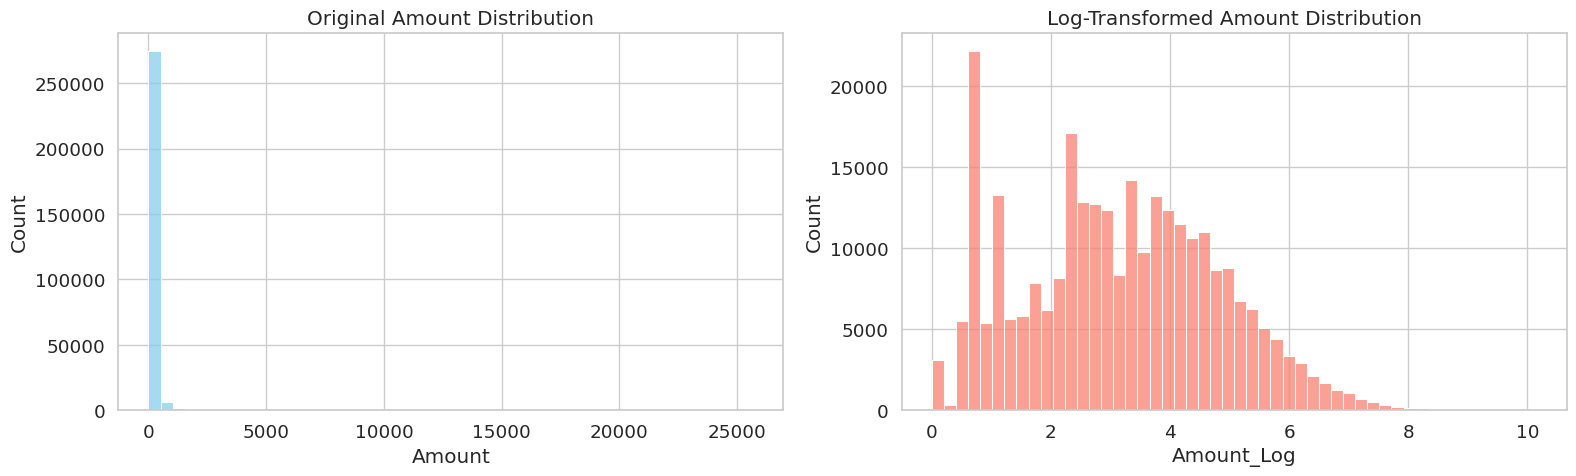

2026-02-19 20:48:57,747 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2026-02-19 20:48:57,752 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


──────────────────────────────


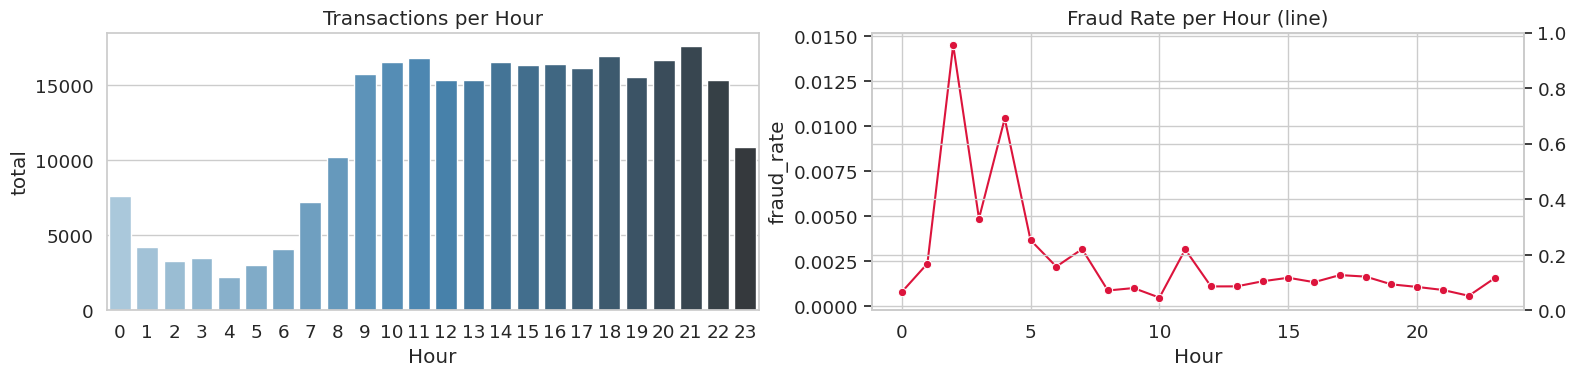

──────────────────────────────


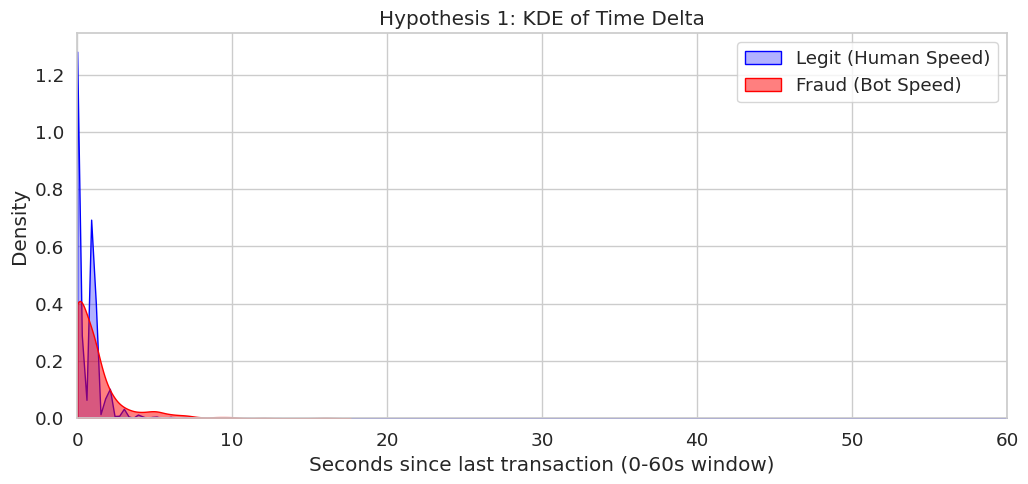

Fraud is constrained to a single burst population, while legit traffic shows periodic batch behavior
──────────────────────────────


──────────────────────────────


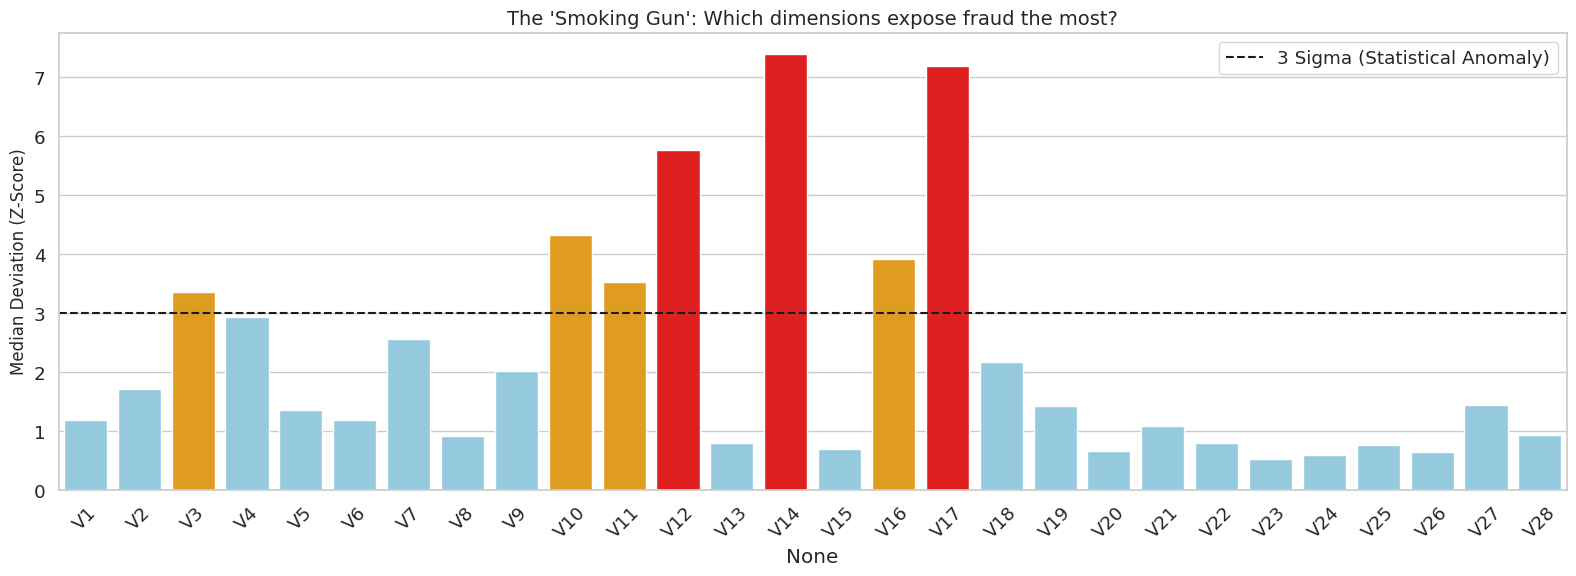

──────────────────────────────

--- Variance Analysis (Anomaly Intensity) ---
Interpretation: Fraud has HIGHER variance in PCA space because it acts as an extreme outlier.


,Legit_Var,Fraud_Var,Anomaly_Intensity
V14,0.799913,18.089792,22.614693
V17,0.560271,48.521583,86.603751
V12,0.893747,20.997753,23.494059
Amount_Log,2.742173,4.896248,1.785536


──────────────────────────────


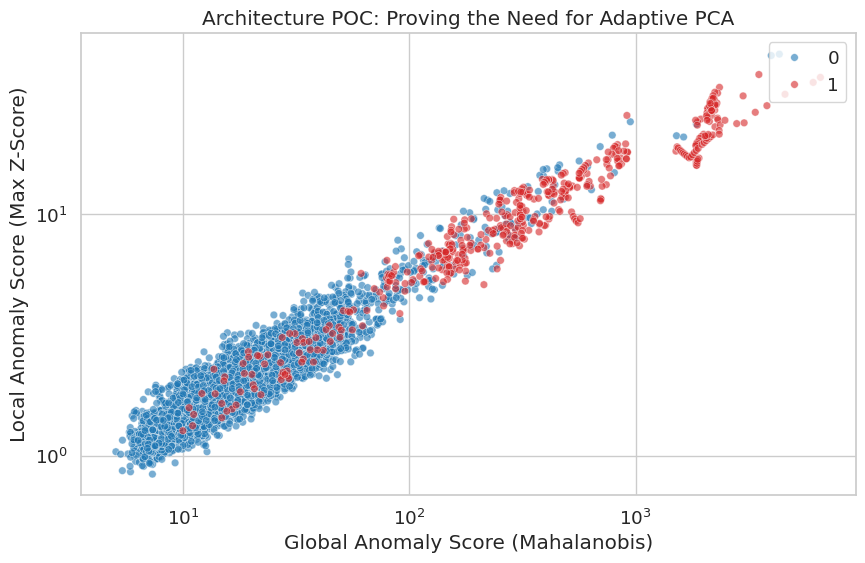

──────────────────────────────


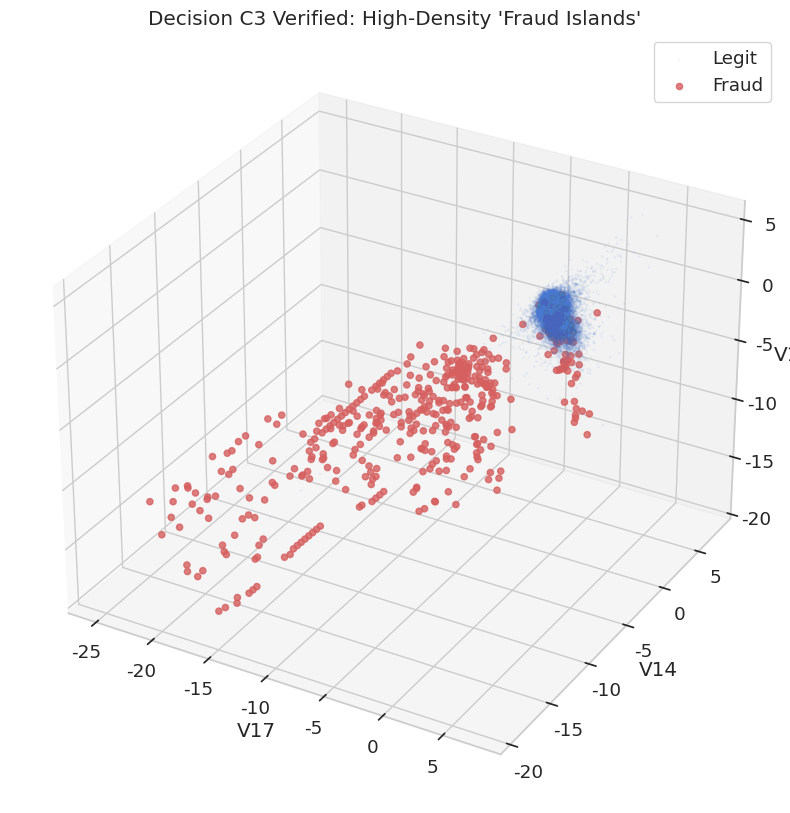

──────────────────────────────


In [5]:
# Define PCA columns & Types
pca_cols = [f'V{i}' for i in range(1, 29)]
cols_to_float = [c for c in df.columns if c != 'Class']

# === 2.1 Transforming Amount Column ===
df['Amount_Log'] = np.log1p(df['Amount'])  # Skewness is sky-high

# Visualize the Transformation
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
sns.histplot(df['Amount'], bins=50, ax=ax[0], color='skyblue')
ax[0].set_title('Original Amount Distribution')
sns.histplot(df['Amount_Log'], bins=50, ax=ax[1], color='salmon')
ax[1].set_title('Log-Transformed Amount Distribution')
plt.tight_layout()
plt.show()
print("──────────────────────────────")

# ------- Time Dimension -------
# Create hour bucket from Time (seconds -> hour)
df['Hour'] = ((df['Time'] // 3600) % 24).astype(int)
hourly = df.groupby('Hour').agg(total=('Class','count'), frauds=('Class','sum')).reset_index()
hourly['fraud_rate'] = hourly['frauds'] / hourly['total']

fig, ax = plt.subplots(1,2, figsize=(16,4))
sns.barplot(x='Hour', y='total', data=hourly, ax=ax[0], palette='Blues_d')
ax[0].set_title('Transactions per Hour')

ax2 = ax[1].twinx()
sns.lineplot(x='Hour', y='fraud_rate', data=hourly, marker='o', ax=ax[1], color='crimson')
ax[1].set_title('Fraud Rate per Hour (line)')

plt.tight_layout()
plt.show()
print("──────────────────────────────")
# ----------------------------------------------

# === 2.2 Hypothesis 1: The "Machine Gun" Effect (Velocity) ===
# This is the graph that looks for bots operate in bursts or in a small window.
# We look at 'Time_Delta' = Seconds since the previous transaction.

df['Time_Delta'] = df['Time'].diff().fillna(1000)

plt.figure(figsize=(12, 5))
# Limiting x-axis to 0-60 seconds to focus on the "Burst"
sns.kdeplot(df[df['Class']==0]['Time_Delta'], clip=(0, 60), label='Legit (Human Speed)', shade=True, color='blue', alpha=0.3)
sns.kdeplot(df[df['Class']==1]['Time_Delta'], clip=(0, 60), label='Fraud (Bot Speed)', shade=True, color='red', alpha=0.5)
plt.title("Hypothesis 1: KDE of Time Delta")
plt.xlabel("Seconds since last transaction (0-60s window)")
plt.xlim(0, 60)
plt.legend()
plt.show()

print("Fraud is constrained to a single burst population, while legit traffic shows periodic batch behavior")
print("──────────────────────────────")

# === 2.3 Hypothesis 2: Cyclical Patterns (Radar Chart) ===
# Feature Prep
df['Hour'] = (df['Time'] // 3600) % 24

# Aggregating for Radar
fraud_hourly = df[df['Class'] == 1]['Hour'].value_counts().sort_index().reindex(range(24), fill_value=0)
legit_hourly = df[df['Class'] == 0]['Hour'].value_counts().sort_index().reindex(range(24), fill_value=0)

# Normalize min-max to compare SHAPE (not volume)
fraud_norm = (fraud_hourly - fraud_hourly.min()) / (fraud_hourly.max() - fraud_hourly.min())
legit_norm = (legit_hourly - legit_hourly.min()) / (legit_hourly.max() - legit_hourly.min())

# Create Radar Chart with Hours Labels
fig = go.Figure()

hours_labels = [f"{h:02d}:00" for h in range(24)]

fig.add_trace(go.Scatterpolar(
    r=legit_norm,
    theta=hours_labels,
    fill='toself',
    name='Legit Pattern',
    line_color='blue', opacity=0.5
))

fig.add_trace(go.Scatterpolar(
    r=fraud_norm,
    theta=hours_labels,
    fill='toself',
    name='Fraud Pattern',
    line_color='red', opacity=0.7
))

fig.update_layout(
    title="Cyclical Forensics: Hourly Activity Shape",
    polar=dict(
        radialaxis=dict(visible=False),
        angularaxis=dict(
            direction="clockwise",
            period=24
        )
    ),
    showlegend=True
)
iplot(fig)
print("──────────────────────────────")

# === 2.4 Hypothesis 3: The "Smoking Gun" (Structure & Variance) ===
# We prove that while V1 captures variance, the 'Tail' (V28) captures noise,
# AND that fraud hides in the middle components (V14, V17).

normal_df = df[df['Class'] == 0]
fraud_df = df[df['Class'] == 1]

means = normal_df[pca_cols].mean()
stds = normal_df[pca_cols].std()

# Whiten the Fraud Data (Z-Score relative to Normal)
fraud_z_scores = (fraud_df[pca_cols] - means) / stds
separation_power = fraud_z_scores.abs().median()

# Visualization
plt.figure(figsize=(16, 6))
colors = ['skyblue' if x < 3 else 'orange' if x < 5 else 'red' for x in separation_power.values]

sns.barplot(x=separation_power.index, y=separation_power.values, palette=colors)
plt.axhline(3, color='k', linestyle='--', label='3 Sigma (Statistical Anomaly)')
plt.title("The 'Smoking Gun': Which dimensions expose fraud the most?", fontsize=14)
plt.ylabel("Median Deviation (Z-Score)", fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
print("──────────────────────────────")

# Variance Analysis (The "Intensity" Proof)
feats_to_analyze = ['V14', 'V17', 'V12', 'Amount_Log']  # Top 3 + Amount_Log for reference
variance_df = df.groupby('Class')[feats_to_analyze].var().T
variance_df.columns = ['Legit_Var', 'Fraud_Var']
variance_df['Anomaly_Intensity'] = variance_df['Fraud_Var'] / variance_df['Legit_Var']

print("\n--- Variance Analysis (Anomaly Intensity) ---")
print("Interpretation: Fraud has HIGHER variance in PCA space because it acts as an extreme outlier.")
display(variance_df)
print("──────────────────────────────")

# === 2.5 Visualizing the "Two Worlds" (Coordinate POC) ===
viz_sample = pd.concat([normal_df.sample(n=5000, random_state=Config.SEED), fraud_df]).copy()
whitened_data = (viz_sample[pca_cols] - means) / stds

viz_sample['POC_Mahalanobis'] = (whitened_data ** 2).sum(axis=1)
viz_sample['POC_Max_Z'] = whitened_data.abs().max(axis=1)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=viz_sample, x='POC_Mahalanobis', y='POC_Max_Z', hue='Class',
    palette={0: '#1f77b4', 1: '#d62728'}, alpha=0.6, s=30
)
plt.yscale('log')
plt.xscale('log')
plt.title("Architecture POC: Proving the Need for Adaptive PCA")
plt.xlabel("Global Anomaly Score (Mahalanobis)")
plt.ylabel("Local Anomaly Score (Max Z-Score)")
plt.legend(loc='upper right')
plt.show()
print("──────────────────────────────")

# === 2.6 3D "Fraud Islands" Geometry ===
subset = df.sample(frac=0.1, random_state=Config.SEED)
fraud_pts = df[df['Class'] == 1]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(subset[subset.Class == 0]['V17'], subset[subset.Class == 0]['V14'], subset[subset.Class == 0]['V12'], c='b',
           alpha=0.05, s=1, label='Legit')
ax.scatter(fraud_pts['V17'], fraud_pts['V14'], fraud_pts['V12'], c='r', alpha=0.8, s=20, label='Fraud')
ax.set_xlabel('V17')
ax.set_ylabel('V14')
ax.set_zlabel('V12')
plt.title("Decision C3 Verified: High-Density 'Fraud Islands'")
plt.legend()
plt.show()
print("──────────────────────────────")

# Phase D: Strategic 3-Way Split & Stability Audit
* **Protocol:** We implement a Strict Chronological Split to prevent "Look-Ahead Bias":
    * Train (Past): Time 0 -> 106,000s (For learning patterns).
    * Validation (Recent Past): 106,000s -> 138,000s (For Optuna Tuning & Threshold Calibration).
    * Test (Future): 138,000s -> End (For Final Audit only).
* **The Shift Test:** Before modeling, we perform a **Kolmogorov-Smirnov (KS) Test** to ensure that the feature distributions in the Test set (Future) have not drifted significantly from the Train set (Past).

In [6]:
# =============================================================================
# 1. Helper Functions (Vectorized & Stateless)
# =============================================================================

def calculate_psi(expected: np.array, actual: np.array, buckets: int = 10) -> float:
    """
    Calculate Population Stability Index (PSI) using vectorized numpy operations.
    High PSI indicates significant shift in distribution.
    """
    def scale_range(input, min, max):
        input += -(np.min(input))
        input /= np.max(input) / (max - min)
        input += min
        return input

    breakpoints = np.arange(0, buckets + 1) / (buckets) * 100
    breakpoints = np.percentile(expected, breakpoints)
    breakpoints = np.unique(breakpoints) # Handle cases with low cardinality

    if len(breakpoints) < 2: return 0.0

    # Calculate frequencies
    expected_percents = np.histogram(expected, breakpoints)[0] / len(expected)
    actual_percents = np.histogram(actual, breakpoints)[0] / len(actual)

    # Avoid division by zero
    expected_percents = np.clip(expected_percents, a_min=0.0001, a_max=None)
    actual_percents = np.clip(actual_percents, a_min=0.0001, a_max=None)

    # Vectorized calculation
    psi_values = (expected_percents - actual_percents) * np.log(expected_percents / actual_percents)
    return np.sum(psi_values)

def calculate_cohens_d(X: pd.DataFrame, y: pd.Series, col: str) -> float:
    """
    Calculates Cohen's D (Effect Size) for a feature regarding the target.
    Measures how well the feature separates Class 0 from Class 1.
    """
    group0 = X.loc[y == 0, col]
    group1 = X.loc[y == 1, col]

    n0, n1 = len(group0), len(group1)
    if n0 < 2 or n1 < 2: return 0.0

    s0, s1 = group0.var(), group1.var()
    # Pooled Standard Deviation
    pooled_std = np.sqrt(((n0 - 1) * s0 + (n1 - 1) * s1) / (n0 + n1 - 2))

    if pooled_std == 0: return 0.0

    return (group1.mean() - group0.mean()) / pooled_std

def calculate_mi(X: pd.DataFrame, y: pd.Series, col: str) -> float:
    """Calculates Mutual Information (Non-linear dependency)."""
    # Filling NaNs is crucial for sklearn's MI
    # Using discrete_features=False assuming continuous variables for speed
    mi = mutual_info_classif(X[[col]].fillna(0), y, discrete_features=False, random_state=Config.SEED)
    return mi[0]

def classify_feature_via_avidance(row):
    """Determines the recommended usage via statistical interpretation"""
    # Noise Filter: If it never had signal, drop it.
    if abs(row['Cohen_Train']) < 0.1 and abs(row['Cohen_Test']) < 0.1:
        return 'DROP (Noise)'

    # Critical Logic:
    # If Status is ROBUST -> Keep (It works in Test)
    # If Status is Stable -> Keep
    # If Status is DRIFT -> Keep (But monitor)
    if row['Status'] in ['ROBUST', 'Stable']:
        return 'WHITELIST (Prime)'

    if row['Status'] == 'DRIFT':
        # Check if it has decent signal
        if abs(row['Cohen_Test']) > 0.2:
            return 'WHITELIST (Secondary)'
        else:
            return 'BLACKLIST (Unstable Noise)'

    return 'BLACKLIST (Dangerous)'

In [7]:
# =============================================================================
# 2. Main Execution Logic
# =============================================================================

print("--- 1. Performing Time-Split Based on Fraud Density ---")

# A. Sort Frauds to determine cutoffs
frauds = df[df['Class'] == 1].sort_values('Time')
n_frauds = len(frauds)

train_cutoff_idx = int(n_frauds * Config.TRAIN_FRAUD_SIZE)
valid_cutoff_idx = int(n_frauds * (Config.TRAIN_FRAUD_SIZE + Config.TEST_FRAUD_SIZE))

# B. Extract Time Thresholds (+1s buffer to ensure inclusion)
time_split_1 = frauds.iloc[train_cutoff_idx]['Time'] + 1
time_split_2 = frauds.iloc[valid_cutoff_idx]['Time'] + 1

print(f"Split Logic Calculated:")
print(f" > Train End / Valid Start: {time_split_1}s ({time_split_1/3600:.1f}h)")
print(f" > Valid End / Test Start:  {time_split_2}s ({time_split_2/3600:.1f}h)")

# C. Apply Split
train_df = df[df['Time'] <= time_split_1].copy()
val_df   = df[(df['Time'] > time_split_1) & (df['Time'] <= time_split_2)].copy()
test_df  = df[df['Time'] > time_split_2].copy()

# D. Stats Report
print("\n--- Split Statistics ---")
stats_report = pd.DataFrame({
    'Set': ['Train', 'Valid', 'Test'],
    'Duration (h)': [
        train_df['Time'].max()/3600,
        (val_df['Time'].max() - val_df['Time'].min())/3600,
        (test_df['Time'].max() - test_df['Time'].min())/3600
    ],
    'Rows': [len(train_df), len(val_df), len(test_df)],
    'Frauds': [train_df['Class'].sum(), val_df['Class'].sum(), test_df['Class'].sum()],
    'Fraud Rate (%)': [train_df['Class'].mean()*100, val_df['Class'].mean()*100, test_df['Class'].mean()*100]
})
print(stats_report.round(2).to_string(index=False))

--- 1. Performing Time-Split Based on Fraud Density ---
Split Logic Calculated:
 > Train End / Valid Start: 92103.0s (25.6h)
 > Valid End / Test Start:  139108.0s (38.6h)

--- Split Statistics ---
  Set  Duration (h)   Rows  Frauds  Fraud Rate (%)
Train         25.58 149304     284            0.19
Valid         13.06  63041      95            0.15
 Test          9.36  71381      94            0.13


## Stability Testing Strategy & Decision Logic

### 1. The Core Philosophy: Time-Aware Validation
We utilize a **Chronological Split** (OOT - Out of Time) instead of random sampling to simulate production reality and prevent *Look-Ahead Bias*.
* **Structure:** `Train` (History) $\rightarrow$ `Valid` (Proxy) $\rightarrow$ `Test` (Future).
* **Goal:** Ensure that the `Valid` set is a reliable proxy for the `Train` set, and that the model generalizes well to the unseen `Test` set.

### 2. The Triangular Analysis Protocol
We analyze the stability of features across three vectors:
1.  **Train $\rightarrow$ Valid:** Is the validation set representative?
2.  **Valid $\rightarrow$ Test:** Does the proxy hold up against the future?
3.  **Train $\rightarrow$ Test:** Long-term drift analysis (Critical for Model Monitoring).

### 3. The Metrics Stack
| Metric | Purpose | Threshold (Config)          |
| :--- | :--- |:----------------------------|
| **PSI (Population Stability Index)** | Measures **Distribution Shift**. Did the histogram shape change? | `> 0.4` (Critical Drift)    |
| **Cohen's D Lift** | Measures **Signal Stability**. Did the feature's ability to separate classes drop? | `< -0.1` (Signal Loss)      |
| **Mutual Information (MI) Lift** | Measures **Non-Linear Dependency**. Did the relationship complexity change? | `< -0.02` (Dependency Loss) |

### 4. Decision Matrix (The "Veto" Logic)
Our final status is determined by a hierarchy of checks. We prioritize **Signal Strength** over pure Distribution Stability.

* 🟢 **STABLE:** No significant changes in PSI or Signal.
* 🔴 **DRIFT:** High PSI detected (Distribution shifted), but signal strength is average.
* 🟠 **DEGRADED:** Distribution is stable, but Signal (Cohen/MI) has dropped significantly. **(High Risk)**
* ⚫ **DRIFT+LOSS:** Both Distribution shifted AND Signal was lost. **(Kill Feature)**
* 🔵 **ROBUST (The Override):** High PSI (Drift) is detected, **BUT** the feature remains strongly predictive (High Cohen's D) and stable in strength.
    * *Action:* **Keep Feature.** Reasoning: The world changed, but the feature still works.

In [8]:
# =============================================================================
# 3. Validation Stability Analysis (Zero Test Leakage)
# =============================================================================
print("\n--- 2. Running Validation-Only Stability Audit ---")

stability_feats = [c for c in df.columns if c.startswith('V')] + ['Amount']
audit_data = []

def classify_feature_via_avidance(row):
    # Noise Filter: If it never had signal, drop it.
    if abs(row['Cohen_Train']) < 0.1 and abs(row['Cohen_Valid']) < 0.1:
        return 'DROP (Noise)'

    if row['Status'] in ['ROBUST', 'Stable']:
        return 'WHITELIST (Prime)'

    if row['Status'] == 'DRIFT':
        if abs(row['Cohen_Valid']) > 0.2:
            return 'WHITELIST (Secondary)'
        else:
            return 'BLACKLIST (Unstable Noise)'

    return 'BLACKLIST (Dangerous)'

for col in stability_feats:
    # ---------------------------------------------------------
    # A. Calculate Base Stats (Train & Valid ONLY)
    # ---------------------------------------------------------
    stats = {}
    for name, subset in [('Train', train_df), ('Valid', val_df)]:
        stats[f'Cohen_{name}'] = calculate_cohens_d(subset, subset['Class'], col)
        stats[f'MI_{name}'] = calculate_mi(subset, subset['Class'], col)

    # ---------------------------------------------------------
    # B. Calculate Drifts (Train -> Valid)
    # ---------------------------------------------------------
    psi_tv = calculate_psi(train_df[col], val_df[col])
    stat_tv, p_tv = ks_2samp(train_df[col], val_df[col])

    # ---------------------------------------------------------
    # C. Calculate Lifts (Focus on Train -> Valid)
    # ---------------------------------------------------------
    cohen_lift_tv = stats['Cohen_Valid'] - stats['Cohen_Train']
    mi_lift_tv = stats['MI_Valid'] - stats['MI_Train']

    # ---------------------------------------------------------
    # D. Determine Status (The "Brain" + "Veto" Logic)
    # ---------------------------------------------------------
    status = "Stable"
    reason = "Normal"

    # Drift Check
    is_drift = (psi_tv > Config.THRESH_PSI_CRIT) or (p_tv < Config.THRESH_P_VAL)

    # Signal Check
    is_crash = abs(stats['Cohen_Valid']) < Config.THRESH_COHEN_CRASH
    is_major_drop = cohen_lift_tv < Config.THRESH_COHEN_LIFT_TOLERANCE
    is_mi_loss = mi_lift_tv < Config.THRESH_MI_LIFT

    if is_drift:
        status = "DRIFT"
        reason = "Dist. Shift"

    if is_major_drop or is_mi_loss:
        status = "DEGRADED" if status == "Stable" else "DRIFT+LOSS"
        reason = "Signal Drop"

    if is_crash:
        status = "DRIFT+LOSS"
        reason = "Signal Crash"

    # The "High Signal" Override (Targeting Valid)
    is_still_strong = abs(stats['Cohen_Valid']) > Config.THRESH_COHEN_STRONG_TEST # Conceptually same threshold

    if is_still_strong:
        if status in ["DRIFT", "DRIFT+LOSS", "DEGRADED"]:
            status = "ROBUST"
            reason = "Strong despite Shift"

    # ---------------------------------------------------------
    # E. Record Data (T->V Metrics Only)
    # ---------------------------------------------------------
    audit_data.append({
        'Feature': col,
        'Status': status,
        'Reason': reason,
        'PSI (T->V)': np.round(psi_tv, 3),
        'KS_Stat (T->V)': np.round(stat_tv, 3),
        'P-Value (T->V)': p_tv,
        'Cohen_Train': np.round(stats['Cohen_Train'], 3),
        'Cohen_Valid': np.round(stats['Cohen_Valid'], 3),
        'Cohen_Lift (T->V)': np.round(cohen_lift_tv, 3),
        'MI_Train': np.round(stats['MI_Train'], 3),
        'MI_Valid': np.round(stats['MI_Valid'], 3),
        'MI_Lift (T->V)': np.round(mi_lift_tv, 3),
    })

audit_df = pd.DataFrame(audit_data)

# Sort by Logic
audit_df['Recommendation'] = audit_df.apply(classify_feature_via_avidance, axis=1)
risk_level_map = {'DROP (Noise)': 4, 'BLACKLIST (Dangerous)': 3, 'BLACKLIST (Unstable Noise)': 2, 'WHITELIST (Secondary)': 1, 'WHITELIST (Prime)': 0} # 0 is lowest risk
audit_df['Risk_Level_Score'] = audit_df['Recommendation'].map(risk_level_map)

# Sort primarily by risk (Highest number = bad), then by original signal strength
audit_df = audit_df.sort_values(['Risk_Level_Score', 'Cohen_Train'], ascending=[False, True]).reset_index(drop=True)

# Display
cols_to_show = [
    'Feature', 'Status', 'Reason', 'Risk_Level_Score', 'Recommendation',
    'PSI (T->V)', 'MI_Lift (T->V)', 'Cohen_Lift (T->V)', 'Cohen_Train', 'Cohen_Valid']
print("\n--- Feature Stability Report (Zero Leakage - Train vs Valid) ---")
display(audit_df[cols_to_show].style.background_gradient(
        subset=['Cohen_Train', 'PSI (T->V)', 'Risk_Level_Score'], cmap='coolwarm'))

rec_lst = audit_df['Recommendation'].tolist()


--- 2. Running Validation-Only Stability Audit ---

--- Feature Stability Report (Zero Leakage - Train vs Valid) ---


,Feature,Status,Reason,Risk_Level_Score,Recommendation,PSI (T->V),MI_Lift (T->V),Cohen_Lift (T->V),Cohen_Train,Cohen_Valid
0,V13,DRIFT+LOSS,Signal Crash,4,DROP (Noise),0.015000,-0.000000,0.072000,-0.049000,0.023000
1,V26,DRIFT+LOSS,Signal Crash,4,DROP (Noise),0.181000,-0.000000,0.030000,0.061000,0.090000
2,V23,DRIFT+LOSS,Signal Crash,3,BLACKLIST (Dangerous),0.191000,-0.000000,0.360000,-0.268000,0.092000
3,V24,DRIFT+LOSS,Signal Crash,3,BLACKLIST (Dangerous),0.196000,0.000000,0.246000,-0.189000,0.057000
4,Amount,DRIFT,Dist. Shift,2,BLACKLIST (Unstable Noise),0.003000,-0.001000,0.035000,0.135000,0.171000
5,V28,DRIFT,Dist. Shift,2,BLACKLIST (Unstable Noise),0.973000,-0.001000,-0.106000,0.231000,0.125000
6,V25,DRIFT,Dist. Shift,1,WHITELIST (Secondary),0.361000,-0.001000,-0.471000,0.147000,-0.324000
7,V17,ROBUST,Strong despite Shift,0,WHITELIST (Prime),0.023000,-0.002000,-1.027000,-8.847000,-9.874000
8,V14,ROBUST,Strong despite Shift,0,WHITELIST (Prime),0.110000,-0.002000,1.577000,-8.192000,-6.615000
9,V12,ROBUST,Strong despite Shift,0,WHITELIST (Prime),0.061000,-0.001000,-0.491000,-6.391000,-6.883000


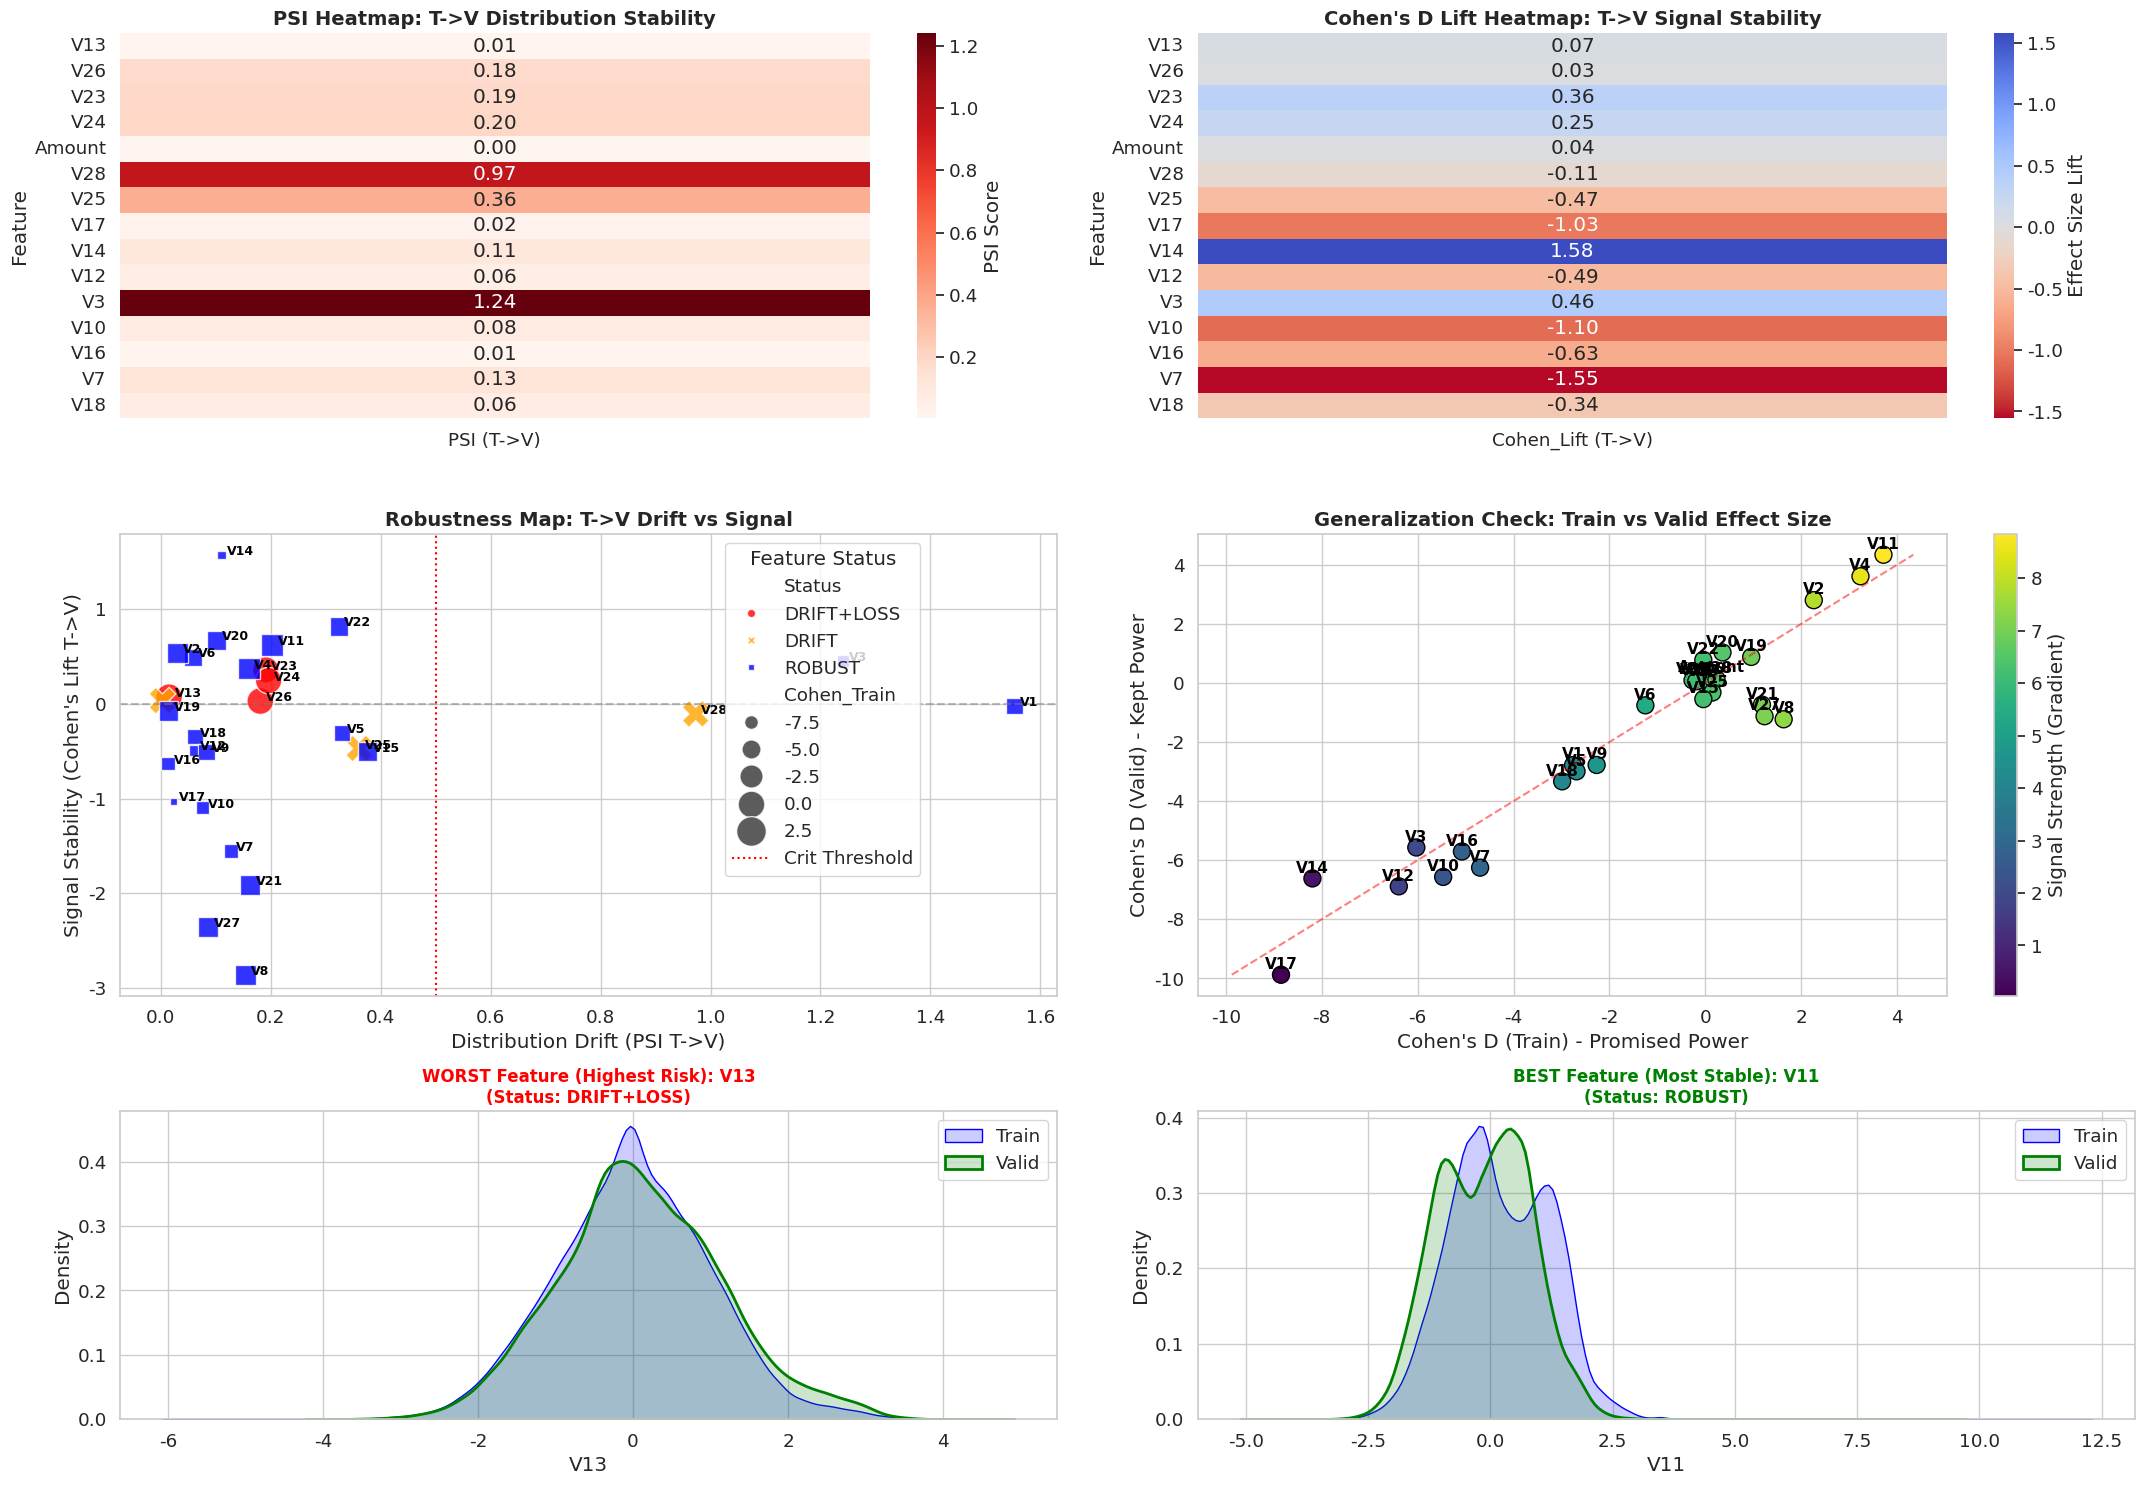

3127

In [9]:
# =============================================================================
# 4. Advanced Visualization (Train vs Valid Logic)
# =============================================================================

# Setup layout
fig = plt.figure(figsize=(26, 18))
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1.2, 0.8], hspace=0.3, wspace=0.15)

# --- Row 1: Heatmaps (Reduced to single vector T->V) ---
top_risk_df = audit_df.head(15).copy()

# 1. PSI Heatmap
ax1 = plt.subplot(gs[0, 0])
sns.heatmap(top_risk_df.set_index('Feature')[['PSI (T->V)']],
            annot=True, fmt=".2f", cmap='Reds', ax=ax1, cbar_kws={'label': 'PSI Score'})
ax1.set_title("PSI Heatmap: T->V Distribution Stability", fontsize=14, fontweight='bold')

# 2. Cohen's D Lift Heatmap
ax2 = plt.subplot(gs[0, 1])
sns.heatmap(top_risk_df.set_index('Feature')[['Cohen_Lift (T->V)']],
            annot=True, fmt=".2f", cmap='coolwarm_r', center=0, ax=ax2, cbar_kws={'label': 'Effect Size Lift'})
ax2.set_title("Cohen's D Lift Heatmap: T->V Signal Stability", fontsize=14, fontweight='bold')

# --- Row 2: Strategy Scatters ---

# 3. Robustness Check (T->V)
ax3 = plt.subplot(gs[1, 0])
scatter1 = sns.scatterplot(
    data=audit_df,
    x='PSI (T->V)',
    y='Cohen_Lift (T->V)',
    hue='Status',
    style='Status',
    size='Cohen_Train',
    sizes=(50, 500),
    palette={'Stable':'green', 'DRIFT':'orange', 'ROBUST':'blue', 'DEGRADED':'purple', 'DRIFT+LOSS':'red'},
    alpha=0.8,
    ax=ax3
)

for i in range(audit_df.shape[0]):
    row = audit_df.iloc[i]
    if row['PSI (T->V)'] > 0.1 or abs(row['Cohen_Lift (T->V)']) > 0.05:
        ax3.text(row['PSI (T->V)']+0.01, row['Cohen_Lift (T->V)'],
                 row['Feature'], fontsize=9, color='black', weight='bold')

ax3.axhline(0, color='grey', linestyle='--', alpha=0.5)
ax3.axvline(Config.THRESH_PSI_CRIT, color='red', linestyle=':', label='Crit Threshold')
ax3.set_title(f"Robustness Map: T->V Drift vs Signal", fontsize=14, fontweight='bold')
ax3.set_xlabel("Distribution Drift (PSI T->V)")
ax3.set_ylabel("Signal Stability (Cohen's Lift T->V)")
ax3.legend(bbox_to_anchor=(0.75, 1), loc='upper center', title='Feature Status')

# 4. Generalization Check (Train vs Valid Effect Size)
ax4 = plt.subplot(gs[1, 1])
norm = plt.Normalize(audit_df['Cohen_Train'].abs().min(), audit_df['Cohen_Train'].abs().max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])

scatter2 = sns.scatterplot(
    data=audit_df,
    x='Cohen_Train',
    y='Cohen_Valid',
    hue='Cohen_Train',
    palette='viridis',
    s=150,
    edgecolor='black',
    ax=ax4,
    legend=False
)

lims = [
    min(min(audit_df['Cohen_Train']), min(audit_df['Cohen_Valid'])),
    max(max(audit_df['Cohen_Train']), max(audit_df['Cohen_Valid']))
]
ax4.plot(lims, lims, '--', color='red', alpha=0.5, label='Perfect Generalization')

for i in range(audit_df.shape[0]):
    row = audit_df.iloc[i]
    ax4.text(row['Cohen_Train'], row['Cohen_Valid']+0.2,
             row['Feature'], fontsize=11, fontweight='bold', color='black', ha='center')

ax4.set_title("Generalization Check: Train vs Valid Effect Size", fontsize=14, fontweight='bold')
ax4.set_xlabel("Cohen's D (Train) - Promised Power")
ax4.set_ylabel("Cohen's D (Valid) - Kept Power")
fig.colorbar(sm, ax=ax4, label="Signal Strength (Gradient)")

# --- Row 3: KDE Proofs (Train & Valid ONLY) ---

def plot_kde_pair(ax, feature, title_prefix, color_band):
    if not feature: return
    sns.kdeplot(train_df[feature], fill=True, color='blue', label='Train', ax=ax, alpha=0.2)
    sns.kdeplot(val_df[feature], fill=True, color='green', label='Valid', ax=ax, alpha=0.2, linewidth=2)
    ax.set_title(f"{title_prefix}: {feature}\n(Status: {audit_df[audit_df['Feature']==feature]['Status'].values[0]})", fontsize=12, fontweight='bold', color=color_band)
    ax.legend()

# 5. Worst Feature
ax5 = plt.subplot(gs[2, 0])
worst_feature = audit_df.iloc[0]['Feature']
plot_kde_pair(ax5, worst_feature, "WORST Feature (Highest Risk)", "red")

# 6. Best Feature
ax6 = plt.subplot(gs[2, 1])
best_feature = audit_df.iloc[-1]['Feature']
plot_kde_pair(ax6, best_feature, "BEST Feature (Most Stable)", "green")

plt.tight_layout()
plt.show()

# Cleanup
del audit_df
gc.collect()

## [D.1] Business Value (ROI) & The Custom Objective

#### Precision-Recall Curve Analysis
**Objective:** Audit the model against the operational constraint.
* **PR-AUC:** Global performance metric on the Test Set.
* **Operational Point:** We fix **Precision >= 80%** (Business Requirement: Low False Positives) and measure the resulting **Recall** (How much fraud do we catch?).

#### Business Value (ROI)
**'Probability to Profit' Objective:**
* **Net Utility:** We calculate ROI using `Log(Amount)` for True Positives minus a fixed `Cost` for False Positives - using a custom formula:
$$ROI = \sum(TP \times \ln(Amount)) - \sum(FP \times Cost)$$
    * This ensures the model prioritizes **high-value fraud** over low-value noise, aligning the algorithmic threshold with business profitability.

#### The Custom Objective Engine (Focal Loss)
**Strategy:** Instead of blunt `scale_pos_weight`, we use **Weighted Focal Loss**.
* **Why:** Focuses the gradient on "Hard Examples" (borderline fraud) and ignores easy wins.
* **Mechanism:** Down-weights easy examples using $(1-p)^\gamma$.
* **Stability:** Uses a robust approximation for the Hessian (Second Derivative) to prevent exploding gradients.

In [10]:
# === Definitions & Helpers ===

def sigmoid(x):
    """Numerically stable sigmoid function."""
    return 1 / (1 + np.exp(-x))

# 1. The native LightGBM form compatible custom objective
def wt_focal_loss_obj(preds, train_data):
    """
    Custom Objective for LightGBM Core API.
    Signature: (preds: Raw Margins, train_data: lgb.Dataset) -> (grad, hess)
    """
    y_true = train_data.get_label()

    # 1. Apply Sigmoid (preds are raw log-odds)
    p = sigmoid(preds)

    # 2. Business Priorities (Sample Weights)
    # If weights were passed to lgb.Dataset, use them. Else default to 1.
    w = train_data.get_weight()
    if w is None:
        w = np.ones_like(y_true)

    # 3. Focal Loss Hyperparameters
    # ALPHA: Balance (higher -> focus on fraud)
    # GAMMA: Focus (higher -> focus on hard examples)
    ALPHA = 0.75
    GAMMA = 2.0

    # 4. Gradients (First Derivative)
    # Vectorized calculation for speed
    grad_pos = (-ALPHA * np.power(1.0 - p, GAMMA) *
                (1.0 - p - GAMMA * p * np.log(np.maximum(p, 1e-7))))
    grad_neg = ((1.0 - ALPHA) * np.power(p, GAMMA) *
                (p + GAMMA * (1.0 - p) * np.log(np.maximum(1.0 - p, 1e-7))))
    grad = np.where(y_true == 1, grad_pos, grad_neg)

    # 5. Hessian (Second Derivative)
    # Using "Sigmoid Hessian" approximation for convexity and stability
    # H = p * (1-p) * modulator
    modulator = np.where(y_true == 1, np.power(1.0 - p, GAMMA), np.power(p, GAMMA))
    hess = (p * (1.0 - p)) * modulator * (1.0 + GAMMA)

    # 6. Apply Weights
    grad *= w
    hess *= w

    return grad, hess

# 2. Universal Predictor (The Bridge)
def predict_proba_unified(model, X):
    """
    Handles probability prediction for ANY model type:
    - Sklearn (RandomForest, XGBClassifier, LGBMClassifier) -> predict_proba()
    - Native LightGBM Booster -> predict() -> Sigmoid (if raw scores)
    """
    if hasattr(model, "predict_proba"):
        # Sklearn-style
        return model.predict_proba(X)[:, 1]
    elif hasattr(model, "predict"):
        # Native Booster
        preds = model.predict(X)
        # Heuristic: If preds are not in [0, 1], assume raw logits and apply sigmoid
        if np.min(preds) < 0 or np.max(preds) > 1:
            return sigmoid(preds)
        return preds
    else:
        raise ValueError("Model type not recognized for prediction.")

# 3. Operational Point Calculator (The "Friction-First" Logic)
def get_operational_metrics(y_true, probs, target_prec=0.80):
    """
    Finds the operational threshold that meets the Precision target (Safety Constraint).

    Logic:
    1. Calculate Precision-Recall Curve.
    2. Filter for points where Precision >= target_prec (e.g., 0.80).
    3. Select the point with the MAXIMUM Recall among valid points.
       (We want to catch as much fraud as possible without annoying more than 20% of customers).

    Returns: threshold, recall, precision, auprc
    """
    precision, recall, thresholds = precision_recall_curve(y_true, probs)
    auprc = average_precision_score(y_true, probs)

    # Find indices where precision >= target
    valid_indices = np.where(precision >= target_prec)[0]

    if len(valid_indices) > 0:  # Optimization: Maximize Recall under constraint
        # We want the highest Recall possible while meeting Precision constraint.
        # In the P-R arrays, higher indices usually mean higher threshold -> higher precision, lower recall.
        # We search for the first point (lowest threshold) that satisfies the condition.
        # Since P-R curve is not monotonic, we take the one with Max Recall among valid ones.
        best_idx = valid_indices[np.argmax(recall[valid_indices])]
        # Handle edge case where best_idx is the last point (length mismatch in sklearn)
        op_thresh = thresholds[best_idx] if best_idx < len(thresholds) else 1.0
        op_recall = recall[best_idx]
        op_prec = precision[best_idx]
    else:
        # Fallback: If model is too weak to reach target precision, maximize Precision itself
        best_idx = np.argmax(precision)
        op_thresh = thresholds[best_idx] if best_idx < len(thresholds) else 1.0
        op_recall = recall[best_idx]
        op_prec = precision[best_idx]

    return op_thresh, op_recall, op_prec, auprc

def get_amt_wts(amounts_arr, reg_floor=50):
    """assess if the amount field's dist. and calculate weights accordingly"""
    # Heuristic: Credit card transactions rarely stay below $50 max.
    # If max < 50, it's almost certainly already log-scaled.
    if np.max(amounts_arr) < reg_floor:
        # Already Logged: Don't log again!
        log_amts = np.expm1(amounts_arr).clip(min=reg_floor, max=100) + amounts_arr
    else:
        # Raw Data: Apply Log
        log_amts = amounts_arr.clip(min=reg_floor, max=100) + np.log1p(amounts_arr)
    return log_amts

# 4. ROI Calculator
def calculate_net_utility(y_true, probs, amts):
    """ Calculates max potential profit based on probabilities. """
    thresholds_ = np.linspace(0.01, 0.99, 200)
    utilities = []

    # Constants
    REGULATORY_FLOOR = 50
    FP_COST = 35 # Avg investigation cost

    y_true_arr = np.array(y_true)

    # --- SMART CHECK: Is it already logged? ---
    amounts_arr = np.array(amts)
    log_amts = get_amt_wts(amounts_arr)

    for t in thresholds_:
        pred = (probs >= t).astype(int)
        tp_mask = (y_true_arr == 1) & (pred == 1)
        fp_mask = (y_true_arr == 0) & (pred == 1)

        gain = np.sum(log_amts[tp_mask])
        loss = np.sum(fp_mask) * FP_COST
        utilities.append(gain - loss)

    max_idx_ = np.argmax(utilities)
    return np.max(utilities), thresholds_[max_idx_]

# 5. Master Evaluator
def evaluate_model_comprehensive(model, X_tst, y_tst, amounts_test, name="Model"):
    """ Runs full audit: AUPRC, Prec@80, ROI. Returns dict + prints summary. """

    # Predict
    probs = predict_proba_unified(model, X_tst)

    # Metrics
    thresh, recall, prec, auprc = get_operational_metrics(y_tst, probs, target_prec=0.80)

    # Pass amounts (Raw or Log is fine now, function handles it)
    roi, roi_thresh = calculate_net_utility(y_tst, probs, amounts_test)

    print(f"─── {name.upper()} REPORT ───")
    print(f"AUPRC:             {auprc:.4f}")
    print(f"Recall @ 80% Prec: {recall:.4f} (Thresh: {thresh:.4f})")
    print(f"Max ROI Score:     ${roi:,.0f} (Thresh: {roi_thresh:.2f})")
    print("─────────────────────────────")

    return {
        'Model': name,
        'AUPRC': auprc,
        'Recall@80Prec': recall,
        'Max_ROI': roi,
        'probs': probs # Keep for plotting later
    }

# 6. Custom Metric for LightGBM Training (feval)
def lgb_recall_at_80_precision(preds, train_data):
    """
    Native Feval for training loop.
    Optimizes RECALL while keeping PRECISION >= 0.80.
    """
    y_true = train_data.get_label()
    probs = sigmoid(preds)

    # We use our operational metric helper
    _, recall, _, _ = get_operational_metrics(y_true, probs, target_prec=0.80)

    # Return format: (eval_name, eval_result, is_higher_better)
    return 'Recall@80Prec', recall, True

# === Params Configuration ===
# 1. Sklearn API Params (Reference)
params_stable = {
    'objective': 'binary',
    'metric': 'custom',     # Suppress default logging
    'verbosity': -1,
    'seed': Config.SEED,
    'deterministic': True,
    'n_jobs': 1,            # CRITICAL for reproducibility
    'force_col_wise': True, # Reduces variance
    'learning_rate': 0.05,
    'n_estimators': 300,
    'colsample_bytree': 0.8,
    'subsample': 0.8
}
# 2. Native API Params (Target)
params_native_lgb = {
    'boosting_type': 'gbdt',
    'verbosity': -1,
    'n_jobs': 1,
    'seed': Config.SEED,
    'deterministic': True,
    'force_col_wise': True,
    'learning_rate': 0.03,
    'num_leaves': 64,
    'max_depth': 8,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': wt_focal_loss_obj,
    'metric': 'None' # We use feval instead
}
print("Unified Toolkit Loaded (Logic: Friction-First Optimization).")

Unified Toolkit Loaded (Logic: Friction-First Optimization).


# Phase E: Feature Engineering (Classes Definition)
**Strategy: The "Signal Amplifier" Pipeline**
We translate our forensic insights into mathematical features:
1.  **Velocity (Time):** Detecting high-frequency bursts (The "Machine Gun" effect).
2.  **Adaptive PCA (Structure):** Measuring the structural anomaly intensity relative to the local timeframe.
3.  **Interaction Geometry:** Amplifying the signal of V14/V17/V12 triangles.
4.  **Autoencoder (Manifold):** A non-linear anomaly detector trained on normal data.

In [11]:
# --------------------------
# Custom Helpers
# --------------------------

class SimpleAE(nn.Module):
    """Internal PyTorch Autoencoder architecture for latent extraction."""
    def __init__(self, input_dim: int, latent_dim: int = 8):
        super(SimpleAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.Tanh(),
            nn.Linear(32, latent_dim),
            nn.Tanh() # Constrain latent space to [-1, 1] for stable Cosine Similarity
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.Tanh(),
            nn.Linear(32, input_dim),
            nn.Sigmoid() # Input is MinMax scaled to [0, 1]
        )

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        latent = self.encoder(x)
        recon = self.decoder(latent)
        return recon, latent


# --------------------------
# Custom Transformers
# --------------------------

class RenameColumnsSafe(BaseEstimator, TransformerMixin):
    """
    Collision-safe column renamer for pandas DataFrames.

    - Applies a regex substitution (e.g., whitespace -> underscore).
    - Ensures uniqueness by appending a deterministic suffix "__{k}" for duplicates.
    - Preserves column order.
    - Supports sklearn's get_feature_names_out.

    Example:
        RenameColumnsSafe(pattern=r"\\s+", repl="_")
    """

    def __init__(
        self,
        pattern: str = r"\s+",
        repl: str = "_",
        max_len: Optional[int] = None,
        lowercase: bool = False,
        strip: bool = True,
    ):
        self.pattern = pattern
        self.repl = repl
        self.max_len = max_len
        self.lowercase = lowercase
        self.strip = strip

    def fit(self, X, y=None):
        if not hasattr(X, "columns"):
            raise TypeError("RenameColumnsSafe expects a pandas DataFrame input.")

        self.feature_names_in_ = list(map(str, X.columns))
        self.feature_names_out_ = self._make_unique(self._normalize(self.feature_names_in_))
        return self

    def transform(self, X):
        check_is_fitted(self, ["feature_names_out_"])
        if not hasattr(X, "columns"):
            raise TypeError("RenameColumnsSafe expects a pandas DataFrame input.")

        X_out = X.copy()
        X_out.columns = self.feature_names_out_
        return X_out

    def get_feature_names_out(self, input_features=None):
        check_is_fitted(self, ["feature_names_out_"])
        return np.array(self.feature_names_out_, dtype=object)

    def _normalize(self, names: list[str]) -> list[str]:
        out = []
        for n in names:
            s = n
            if self.strip:
                s = s.strip()
            s = re.sub(self.pattern, self.repl, s)
            if self.lowercase:
                s = s.lower()
            if self.max_len is not None and self.max_len > 0:
                s = s[: self.max_len]
            # Avoid empty names
            if s == "":
                s = "col"
            out.append(s)
        return out

    @staticmethod
    def _make_unique(names: list[str]) -> list[str]:
        """
        Make names unique by appending '__{k}' where k is a 1-based counter per name.
        Deterministic given the input order.
        """
        counts: Counter[str] = Counter()
        unique = []
        for n in names:
            counts[n] += 1
            if counts[n] == 1:
                unique.append(n)
            else:
                unique.append(f"{n}__{counts[n]}")
        return unique


class TemporalContextEngineer(BaseEstimator, TransformerMixin):
    """
    1) Time related signals
    2) 'Burst' features: How fast is the stream moving?

    Notes:
    - Expects a pandas DataFrame input (for column-based operations).
    - Does not mutate input X (works on a copy).
    - Implements set_output + get_feature_names_out to support Pipeline.set_output("pandas").
    """

    def __init__(self, round_decimals: int = 12):
        self.round_decimals = round_decimals
        self._transform_output = None  # kept for sklearn API compatibility

    def set_output(self, transform=None):
        self._transform_output = transform
        return self

    def fit(self, X, y=None):
        if not hasattr(X, "columns"):
            raise TypeError("TemporalContextEngineer expects a pandas DataFrame input.")
        if "Time" not in X.columns:
            raise ValueError("TemporalContextEngineer requires a 'Time' column.")

        self.feature_names_in_ = list(X.columns)
        self.n_features_in_ = X.shape[1]
        self.has_amount_ = "Amount" in X.columns
        self.has_amount_log_in_ = "Amount_Log" in X.columns

        # Fallback mean delta-time for cold-start inside each partition (train/val/test)
        self.mean_t_diff_ = float(np.round(np.mean(X["Time"].diff()), self.round_decimals))

        # Pre-compute output feature names (best-effort)
        drop_cols = {"Hour", "Amount", "Time", "Time_Diff"}
        base_out = [c for c in self.feature_names_in_ if c not in drop_cols]

        created = ["Hour_Sin", "Hour_Cos", "Velocity_Freq", "Velocity_Accel"]
        if self.has_amount_:
            created += ["Amount_Hour_Ratio", "Amount_Log"]
        else:
            if self.has_amount_log_in_ and "Amount_Log" not in base_out:
                created += ["Amount_Log"]

        out = list(base_out)
        for c in created:
            if c not in out:
                out.append(c)

        self._feature_names_out = out
        return self

    def get_feature_names_out(self, input_features=None):
        check_is_fitted(self, ["_feature_names_out"])
        return np.array(self._feature_names_out, dtype=object)

    def transform(self, X):
        check_is_fitted(self, ["mean_t_diff_", "feature_names_in_"])
        if not hasattr(X, "columns"):
            raise TypeError("TemporalContextEngineer expects a pandas DataFrame input.")

        X_out = X.copy()

        # Cyclical time
        X_out["Hour"] = (X_out["Time"] // 3600) % 24
        X_out["Hour_Sin"] = np.round(np.sin(2 * np.pi * X_out["Hour"] / 24), self.round_decimals)
        X_out["Hour_Cos"] = np.round(np.cos(2 * np.pi * X_out["Hour"] / 24), self.round_decimals)

        # Amount-derived (anti-leakage: expanding mean uses shift(1))
        if "Amount" in X_out.columns:
            hour_mean = X_out.groupby("Hour")["Amount"].transform(lambda s: s.expanding().mean().shift(1))
            hour_mean = hour_mean.fillna(X_out["Amount"].mean())
            X_out["Amount_Hour_Ratio"] = np.round(X_out["Amount"] / (hour_mean + 1e-5), self.round_decimals)
            if "Amount_Log" not in X_out.columns:
                X_out["Amount_Log"] = np.round(np.log1p(X_out["Amount"]), self.round_decimals)

        # Delta time (cold-start within each split)
        X_out["Time_Diff"] = X_out["Time"].diff().fillna(self.mean_t_diff_ * 2)

        # Velocity / acceleration
        X_out["Velocity_Freq"] = np.round(1.0 / (X_out["Time_Diff"] + 0.1), self.round_decimals)
        X_out["Velocity_Accel"] = np.round(X_out["Velocity_Freq"].diff().fillna(0), self.round_decimals)

        return X_out.drop(columns=["Hour", "Amount", "Time", "Time_Diff"], errors="ignore")


class AutoencoderFeature(BaseEstimator, TransformerMixin):
    """
    Trains ONLY on Class 0 to learn the 'Normal Manifold'.

    Notes:
    - Expects a pandas DataFrame input.
    - Does not mutate input X.
    - Builds Amount_Log on a copy (if Amount exists).
    """

    def __init__(self, cols=None, hidden_layer_sizes=(16, 8, 16), max_iter=100, round_decimals: int = 12):
        self.cols = cols
        self.hidden_layer_sizes = hidden_layer_sizes
        self.max_iter = max_iter
        self.round_decimals = round_decimals

        self.scaler = StandardScaler()
        self.model = MLPRegressor(
            hidden_layer_sizes=self.hidden_layer_sizes,
            activation="tanh",
            solver="adam",
            max_iter=self.max_iter,
            random_state=Config.SEED,
        )

    def set_output(self, transform=None):
        # Not strictly required in your current usage, but keeps it pipeline-compatible.
        self._transform_output = transform
        return self

    def _ensure_amount_log(self, X: pd.DataFrame) -> pd.DataFrame:
        X_ = X.copy()
        if "Amount" in X_.columns and "Amount_Log" not in X_.columns:
            X_["Amount_Log"] = np.round(np.log1p(X_["Amount"]), self.round_decimals)
        return X_

    @staticmethod
    def _default_v_cols(X: pd.DataFrame) -> list[str]:
        # Only V{number} columns (prevents accidentally including polynomial names like "V17 V14")
        return [c for c in X.columns if re.fullmatch(r"V\d+", str(c))]

    def fit(self, X: pd.DataFrame, y: pd.Series):
        if not hasattr(X, "columns"):
            raise TypeError("AutoencoderFeature expects a pandas DataFrame input.")
        if y is None:
            raise ValueError("AutoencoderFeature.fit requires y (to filter Class 0).")

        X_ = self._ensure_amount_log(X)

        if self.cols is None:
            cols = self._default_v_cols(X_)
            if "Amount_Log" in X_.columns:
                cols = cols + ["Amount_Log"]
            self.cols = cols

        missing = [c for c in self.cols if c not in X_.columns]
        if missing:
            raise ValueError(f"AutoencoderFeature missing columns: {missing}")

        X_normal = X_.loc[y == 0, self.cols]
        X_scaled = self.scaler.fit_transform(X_normal)
        self.model.fit(X_scaled, X_scaled)
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        check_is_fitted(self, ["cols"])
        X_ = self._ensure_amount_log(X)

        X_sc = self.scaler.transform(X_[self.cols])
        X_rec = self.model.predict(X_sc)

        mae = np.round(np.mean(np.abs(X_sc - X_rec), axis=1), self.round_decimals)
        return pd.DataFrame({"AE_Recon_Error": mae}, index=X.index)

    def get_feature_names_out(self, input_features=None):
        return np.array(["AE_Recon_Error"], dtype=object)


class PyTorchLatentGeometryTransformer(BaseEstimator, TransformerMixin):
    """
    SKLearn-compatible Transformer that trains a PyTorch Autoencoder,
    extracts the latent representation, calculates the centroid of the NORMAL class,
    and returns the Cosine Similarity of each sample to that centroid.
    """
    def __init__(self, latent_dim: int = 8, epochs: int = 15, batch_size: int = 2048,
                 lr: float = 0.005, random_state: int = 42):
        self.latent_dim = latent_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.lr = lr
        self.random_state = random_state

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model: Optional[nn.Module] = None
        self.centroid: Optional[np.ndarray] = None
        self.scaler = MinMaxScaler()
        self.feature_names_in_: Optional[np.ndarray] = None

    def fit(self, X: pd.DataFrame, y: pd.Series) -> 'PyTorchLatentGeometryTransformer':
        """Trains the AE and calculates the normal centroid."""
        torch.manual_seed(self.random_state)
        self.feature_names_in_ = X.columns.values

        # 1. Scale Data
        X_scaled = self.scaler.fit_transform(X)
        X_t = torch.tensor(X_scaled, dtype=torch.float32).to(self.device)

        # 2. Setup Model & DataLoader
        self.model = SimpleAE(input_dim=X.shape[1], latent_dim=self.latent_dim).to(self.device)
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        criterion = nn.MSELoss()

        loader = DataLoader(TensorDataset(X_t), batch_size=self.batch_size, shuffle=True)

        # 3. Train Autoencoder
        self.model.train()
        for epoch in range(self.epochs):
            for X_b, in loader:
                optimizer.zero_grad()
                recon, _ = self.model(X_b)
                loss = criterion(recon, X_b)
                loss.backward()
                optimizer.step()

        # 4. Extract Latent Space & Calculate Centroid
        self.model.eval()
        with torch.no_grad():
            _, latent_all = self.model(X_t)
            latent_np = latent_all.cpu().numpy()

        # Extract centroid strictly from Normal class (0)
        y_np = y.values
        normal_mask = (y_np == 0)
        if not np.any(normal_mask):
            raise ValueError("No normal class (0) found in y during fit.")

        self.centroid = np.mean(latent_np[normal_mask], axis=0)

        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """Calculates cosine similarity of X to the fitted normal centroid."""
        if self.model is None or self.centroid is None:
            raise RuntimeError("Transformer must be fitted before calling transform.")

        X_scaled = self.scaler.transform(X)
        X_t = torch.tensor(X_scaled, dtype=torch.float32).to(self.device)

        self.model.eval()
        with torch.no_grad():
            _, latent = self.model(X_t)
            latent_np = latent.cpu().numpy()

        # Compute Cosine Similarity (latent vs centroid)
        sims = cosine_similarity(latent_np, self.centroid.reshape(1, -1)).flatten()

        return pd.DataFrame({'Latent_Cos': sims}, index=X.index)

    def get_feature_names_out(self, input_features=None) -> np.ndarray:
        return np.array(['Latent_Cos'])


class AdaptivePCAAnomalyExtractor(BaseEstimator, TransformerMixin):
    """
    Time-Aware Feature Extractor for PCA Data (Production Grade).

    Why this works:
    Standard PCA anomaly detection fails when data drifts (e.g., V14 mean shifts over months).
    This class uses ADAPTIVE normalization (Rolling Windows) to compare each transaction
    against the 'local normal' of the recent past, rather than a frozen global average.

    Key Features:
    - Zero Side Effects: Does not mutate input X.
    - Continuity: Preserves rolling stats context between Train and Test sets.
    - Drift Handling: Supports both rolling (adaptive) and static modes.

    Pre-requisites:
    - Expects DataFrame input containing the PCA components V1..V28.
    - Input DataFrame must be SORTED by Time.

    Notes:
    - Does not mutate input X.
    - Keeps continuity via `last_window_` (you currently manage it manually between splits).
    """

    def __init__(
        self,
        window_size: int = 2000,
        anomaly_percentile: float = 99.9,
        drift_handling: str = "rolling",   # "rolling" or "static"
        verbose: bool = True,
        round_decimals: int = 12,
        update_state: bool = False,
        time_col: str = "Time",
        enforce_monotonic_time: bool = True,
        min_periods: int = 100,
        ):
        """
        Args:
            window_size (int): Number of past transactions to define 'Normal'.
            anomaly_percentile (float): Threshold for binary flagging (e.g., 99.9).
            drift_handling (str): 'rolling' (Adaptive) or 'static' (Frozen at fit).
            verbose (bool): Print status messages.
        """
        self.window_size = window_size
        self.anomaly_percentile = anomaly_percentile
        self.drift_handling = drift_handling
        self.verbose = verbose
        self.round_decimals = round_decimals

        self.update_state = update_state
        self.time_col = time_col
        self.enforce_monotonic_time = enforce_monotonic_time
        self.min_periods = min_periods

        # Learned Attributes (Initialized to None as per sklearn standard)
        self.threshold_max_z_ = None
        self.threshold_mahalanobis_ = None
        self.feature_names_in_ = None

        # Fallback stats (Global mean/std for cold start if no history exists)
        self.fallback_means_ = None
        self.fallback_stds_ = None

        # Continuity Context (Tail of the training data)
        self.last_window_ = None

        # Hardcoded PCA columns as per dataset spec
        self.pca_cols = [f'V{i}' for i in range(1, 29)]
        self._transform_output = None

    # ---- sklearn output API compatibility ----
    def set_output(self, transform=None):
        self._transform_output = transform
        return self

    def get_feature_names_out(self, input_features=None):
        return np.array(
            [
                "pca_adaptive_max_z",
                "pca_adaptive_mahalanobis",
                "flag_adaptive_outlier_z",
                "flag_adaptive_outlier_mahal",
            ],
            dtype=object,
        )

    # ---- state controls ----
    def reset_state(self):
        """Reset streaming context. Call between experiments/runs if update_state=True."""
        self.last_window_ = None
        self._last_time_seen_ = None
        return self

    # ---- internal guards ----
    def _validate_input_df(self, X: pd.DataFrame):
        if not hasattr(X, "columns"):
            raise TypeError("AdaptivePCAAnomalyExtractor expects a pandas DataFrame input.")
        missing = [c for c in self.pca_cols if c not in X.columns]
        if missing:
            raise ValueError(f"AdaptivePCAAnomalyExtractor missing PCA columns: {missing}")

    def _check_time_monotonic(self, X: pd.DataFrame):
        if not self.enforce_monotonic_time:
            return

        if self.time_col not in X.columns:
            return  # no time column, nothing to check

        t = X[self.time_col].to_numpy()

        # Check non-decreasing within the batch
        if t.size >= 2 and np.any(np.diff(t) < 0):
            raise ValueError(
                f"Time column '{self.time_col}' is not non-decreasing within the provided batch."
            )

        # Check non-decreasing across batches in streaming mode
        if self.update_state and getattr(self, "_last_time_seen_", None) is not None and t.size >= 1:
            if t[0] < self._last_time_seen_:
                raise ValueError(
                    f"Time column '{self.time_col}' appears to go backwards across calls: "
                    f"first={t[0]} < last_seen={self._last_time_seen_}."
                )

    # ---- core API ----
    def fit(self, X, y=None):
        """
        Learns the fallback statistics, saves the training tail for continuity,
        and calibrates the anomaly thresholds.
        """
        # 0. Validation & Copy (Prevent Mutation)
        self._validate_input_df(X)
        self._check_time_monotonic(X)

        self.feature_names_in_ = list(X.columns)
        X_pca = X[self.pca_cols].copy()

        # 1. Learn Global Fallback Stats (Used to fill NaNs at very start)
        self.fallback_means_ = np.round(X_pca.mean(), self.round_decimals)
        self.fallback_stds_ = np.round(X_pca.std(), self.round_decimals)

        # 2. Save Context for Continuity (The Fix for Cold Start)
        # We store the last N rows of train to prepend to Test later.
        if self.drift_handling == 'rolling':
            self.last_window_ = X_pca.iloc[-self.window_size:].copy()

        # 3. Calibrate Thresholds on Train Data
        # Note: Internal call uses _adaptive_transform without context injection
        # because Train is the start of the stream.
        features = self._adaptive_transform(X_pca)

        self.threshold_max_z_ = np.round(
                np.nanpercentile(features['pca_adaptive_max_z'], self.anomaly_percentile), self.round_decimals)
        self.threshold_mahalanobis_ = np.round(
                np.nanpercentile(features['pca_adaptive_mahalanobis'], self.anomaly_percentile), self.round_decimals)

        # Streaming time watermark
        if self.update_state and self.time_col in X.columns and len(X) > 0:
            self._last_time_seen_ = X[self.time_col].iloc[-1]

        if self.verbose:
            print(
                f"[AdaptivePCA] Fitted on {len(X)} samples. "
                f"Max Z threshold: {self.threshold_max_z_:.4f}, "
                f"Mahalanobis threshold: {self.threshold_mahalanobis_:.4f}"
            )

        return self

    def fit_transform(self, X, y=None, **fit_params):
        """
        Special override for the initial training pass.
        We don't want to prepend 'last_window_' to X_train because X_train IS the history.
        """
        # 1. Fit the data (learns stats, saves the tail for future calls)
        self.fit(X, y)

        # 2. Temporarily hide the streaming state
        saved_window = self.last_window_
        saved_time = getattr(self, "_last_time_seen_", None)

        self.last_window_ = None
        self._last_time_seen_ = None

        # 3. Transform X as a standalone block (no prepending)
        features = self.transform(X)

        # 4. Restore the streaming state so Validation/Test can use Train's tail
        self.last_window_ = saved_window
        self._last_time_seen_ = saved_time

        return features

    def transform(self, X):
        """
        Applies adaptive feature extraction.
        Handles continuity by prepending the last seen training window if available.
        """
        # 0. Validation & Copy
        check_is_fitted(self, ["fallback_means_", "fallback_stds_", "threshold_max_z_", "threshold_mahalanobis_"])

        self._validate_input_df(X)
        self._check_time_monotonic(X)

        X_pca = X[self.pca_cols].copy()

        # 1. Context Injection (Handling the Gap)
        # If we are in rolling mode and have history, prepend it to ensure
        # the first rows of X calculate their rolling stats against valid history.
        if self.drift_handling == 'rolling' and self.last_window_ is not None:
            # Check if this looks like a sequential call (Test set)
            # We concat [Last_Train, Current_Test]
            X_combined = pd.concat([self.last_window_, X_pca])

            # Run the calculation on the combined set
            features_combined = self._adaptive_transform(X_combined)

            # Slice off the history part to return only the result for X
            # (We remove exactly the number of rows we added)
            features = features_combined.iloc[len(self.last_window_):].copy()

            # Restore index (concat might mess it up if indices overlap)
            features.index = X.index

        else:
            # Standard transform (e.g., on Train set or if static)
            features = self._adaptive_transform(X_pca)

        # 2. Generate Binary Flags
        features['flag_adaptive_outlier_z'] = (features['pca_adaptive_max_z'] > self.threshold_max_z_).astype(int)
        features['flag_adaptive_outlier_mahal'] = (
            features['pca_adaptive_mahalanobis'] > self.threshold_mahalanobis_).astype(int)

        # Optional streaming state update (automatic chaining)
        if self.update_state and self.drift_handling == "rolling":
            self.last_window_ = X_pca.iloc[-self.window_size:].copy()

            if self.time_col in X.columns and len(X) > 0:
                self._last_time_seen_ = X[self.time_col].iloc[-1]

        return features

    def _adaptive_transform(self, X):
        """
        Internal engine: Calculates Rolling Z-Scores.
        Input X is assumed to be the correct window (potentially including prepended context).
        """
        if self.drift_handling == 'rolling':
            # A. Rolling Stats
            # shift(1) is CRITICAL: Row T's stats are calculated from T-N to T-1.
            # This prevents leakage (Row T cannot be part of its own 'normal' baseline).
            rolling_means = np.round(X.rolling(window=self.window_size, min_periods=100).mean().shift(1), self.round_decimals)
            rolling_stds = np.round(X.rolling(window=self.window_size, min_periods=100).std().shift(1), self.round_decimals)

            # B. Fill Warmup
            rolling_means = rolling_means.fillna(self.fallback_means_)
            rolling_stds = rolling_stds.fillna(self.fallback_stds_)
        else:
            # Static Mode (Standard Scaling)
            rolling_means = self.fallback_means_
            rolling_stds = self.fallback_stds_

        # Safety
        rolling_stds[rolling_stds == 0] = 1e-9

        # C. Whiten (Standardize)
        # Z = (Value - Mean) / Std
        whitened = np.round((X - rolling_means) / rolling_stds, self.round_decimals)

        # D. Signal Extraction
        out_df = pd.DataFrame(index=X.index)

        # Max Z (Local): The single worst deviation in any dimension
        out_df['pca_adaptive_max_z'] = whitened.abs().max(axis=1)

        # Mahalanobis (Global): Sum of squared deviations
        out_df['pca_adaptive_mahalanobis'] = np.round((whitened ** 2).sum(axis=1), self.round_decimals)

        return out_df

### [Step E.1] Pipeline Execution
* **Action:** Applying Feature Engineering to Train, Validation, and Test sets.
* **Critical:** Ensuring chronological continuity for Adaptive PCA (Train -> Valid -> Test).


--- Phase E: Applying Base Feature Engineering ---
>> Step 1: Temporal Context & Polynomials...
<class 'pandas.core.frame.DataFrame'> (149304, 70)
>> Step 2: Training Base Autoencoder (Reconstruction Magnitude)...
>> Step 3: Training PyTorch Latent Extractor (Geometry Direction)...
>> Step 4: Applying Adaptive PCA Anomaly Extractor...
[AdaptivePCA] Fitted on 149304 samples. Max Z threshold: 20.5209, Mahalanobis threshold: 1178.4700

--- Engineering Complete ---
Train Shape: (149304, 76)
Valid Shape: (63041, 76)
Test Shape:  (71381, 76)
('Sets Final Columns Post Pipeline:\n'
 "['V17', 'V14', 'V12', 'V10', 'V4', 'Amount_Log', 'V17_V14', 'V17_V12', "
 "'V17_V10', 'V17_V4', 'V17_Amount_Log', 'V14_V12', 'V14_V10', 'V14_V4', "
 "'V14_Amount_Log', 'V12_V10', 'V12_V4', 'V12_Amount_Log', 'V10_V4', "
 "'V10_Amount_Log', 'V4_Amount_Log', 'V17_V14_V12', 'V17_V14_V10', "
 "'V17_V14_V4', 'V17_V14_Amount_Log', 'V17_V12_V10', 'V17_V12_V4', "
 "'V17_V12_Amount_Log', 'V17_V10_V4', 'V17_V10_Amount_Log',

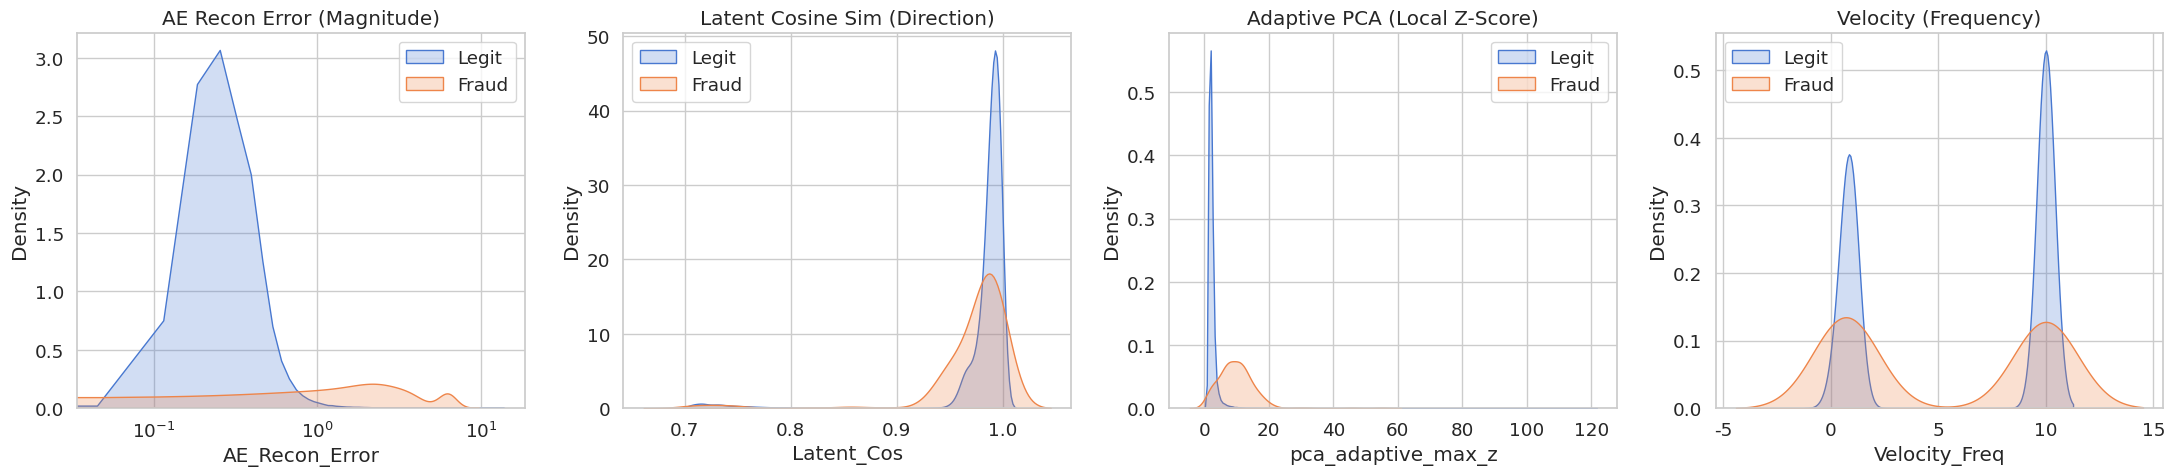

In [12]:
# === Execution ===
print("\n--- Phase E: Applying Base Feature Engineering ---")

# 0. Split X/y to prevent leakage (Targets are removed from X)
y_train = train_df["Class"].copy()
y_val   = val_df["Class"].copy()
y_test  = test_df["Class"].copy()

X_train = train_df.drop(columns=["Class"])
X_val   = val_df.drop(columns=["Class"])
X_test  = test_df.drop(columns=["Class"])

# 1. Base Pipeline: Temporal Context & Polynomial Interactions
# -----------------------------------------------------------
print(">> Step 1: Temporal Context & Polynomials...")
poly_subset = ["V17", "V14", "V12", "V10", "V4", "Amount_Log"]
poly = PolynomialFeatures(degree=3, interaction_only=True, include_bias=False)

inter = ColumnTransformer(
    transformers=[("poly", poly, poly_subset)],
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")

pipe = Pipeline(
    steps=[
        ("temp", TemporalContextEngineer()),
        ("inter", inter),  # must output pandas
        ("rename", RenameColumnsSafe(pattern=r"\s+", repl="_")),
    ]
).set_output(transform="pandas")

train_eng = pipe.fit_transform(X_train, y_train)
val_eng   = pipe.transform(X_val)
test_eng  = pipe.transform(X_test)

print(type(train_eng), getattr(train_eng, "shape", None))

# 2. Sklearn Autoencoder (Reconstruction Error)
# -----------------------------------------------------------
print(">> Step 2: Training Base Autoencoder (Reconstruction Magnitude)...")
ae_model = AutoencoderFeature()
ae_model.fit(X_train, y_train)

train_eng["AE_Recon_Error"] = ae_model.transform(X_train)["AE_Recon_Error"]
val_eng["AE_Recon_Error"]   = ae_model.transform(X_val)["AE_Recon_Error"]
test_eng["AE_Recon_Error"]  = ae_model.transform(X_test)["AE_Recon_Error"]

# 3. PyTorch Latent Geometry (Cosine Similarity) -> NEW!
# -----------------------------------------------------------
print(">> Step 3: Training PyTorch Latent Extractor (Geometry Direction)...")
# Note: We pass X_train_raw to avoid scaling issues (the transformer handles its own scaling)
latent_geo_transformer = PyTorchLatentGeometryTransformer(latent_dim=8, epochs=15)

train_latent_cos_df = latent_geo_transformer.fit_transform(X_train, y_train)
val_latent_cos_df   = latent_geo_transformer.transform(X_val)
test_latent_cos_df  = latent_geo_transformer.transform(X_test)

train_eng = pd.concat([train_eng, train_latent_cos_df], axis=1)
val_eng   = pd.concat([val_eng, val_latent_cos_df], axis=1)
test_eng  = pd.concat([test_eng, test_latent_cos_df], axis=1)

# 4. Adaptive PCA Anomaly Extractor (Rolling Context Chaining)
# -----------------------------------------------------------
print(">> Step 4: Applying Adaptive PCA Anomaly Extractor...")
adaptive_pca = AdaptivePCAAnomalyExtractor(
    window_size=2000,
    anomaly_percentile=99.9,
    drift_handling="rolling",
    update_state=True,
    enforce_monotonic_time=True,                     # optional guard (requires Time column)
    time_col="Time",
)
adaptive_pca.reset_state()                           # recommended at start of a run
train_adaptive = adaptive_pca.fit_transform(X_train) # Fit_Transform Train (via dedicated override)
val_adaptive  = adaptive_pca.transform(X_val)        # Uses Train's tail & updates to end-of-val
test_adaptive = adaptive_pca.transform(X_test)       # Uses Val's tail & updates to end-of-test

# Merge
train_eng = pd.concat([train_eng, train_adaptive], axis=1)
val_eng   = pd.concat([val_eng, val_adaptive], axis=1)
test_eng  = pd.concat([test_eng, test_adaptive], axis=1)

print("\n--- Engineering Complete ---")
print(f"Train Shape: {train_eng.shape}")
print(f"Valid Shape: {val_eng.shape}")
print(f"Test Shape:  {test_eng.shape}")
pprint(f"Sets Final Columns Post Pipeline:\n{train_eng.columns.tolist()}")

# === VISUALIZATION: Proof of Separation (Train Data) ===
print("\n--- Visualizing Feature Separation (Train Data) ---")
fig, axes = plt.subplots(1, 4, figsize=(22, 5))

# 1) Autoencoder separation (Magnitude)
sns.kdeplot(train_eng.loc[y_train == 0, "AE_Recon_Error"], label="Legit", ax=axes[0], fill=True)
sns.kdeplot(train_eng.loc[y_train == 1, "AE_Recon_Error"], label="Fraud", ax=axes[0], fill=True)
axes[0].set_xscale("log")
axes[0].set_title("AE Recon Error (Magnitude)")

# 2) PyTorch Latent Cosine (Direction)
sns.kdeplot(train_eng.loc[y_train == 0, "Latent_Cos"], label="Legit", ax=axes[1], fill=True)
sns.kdeplot(train_eng.loc[y_train == 1, "Latent_Cos"], label="Fraud", ax=axes[1], fill=True)
axes[1].set_title("Latent Cosine Sim (Direction)")

# 3) Adaptive PCA max Z
sns.kdeplot(train_eng.loc[y_train == 0, "pca_adaptive_max_z"], label="Legit", ax=axes[2], fill=True)
sns.kdeplot(train_eng.loc[y_train == 1, "pca_adaptive_max_z"], label="Fraud", ax=axes[2], fill=True)
axes[2].set_title("Adaptive PCA (Local Z-Score)")

# 4) Velocity frequency
sns.kdeplot(train_eng.loc[y_train == 0, "Velocity_Freq"], label="Legit", ax=axes[3], fill=True)
sns.kdeplot(train_eng.loc[y_train == 1, "Velocity_Freq"], label="Fraud", ax=axes[3], fill=True)
axes[3].set_title("Velocity (Frequency)")

for ax in axes:
    ax.legend()
plt.tight_layout()
plt.show()

# Phase F: The "Triple Gun" Feature Selection
**Strategy:** We use a 3-layered validation protocol to ensure only high-value signals survive.
1.  **Gun 1 (Drift):** Remove non-stationary features via Adversarial Drift Regulator (Train vs Valid), Protected by Whitelist.
2.  **Gun 2 (Noise Rejection):** Time-Aware Boruta + SHAP (Running on Random Forest, Multi-Seed Consensus).
3. **Gun 3 (Business Value):** Operational Point Analysis (Precision-Recall + ROI) to ensure features contribute to real-world impact.


--- Phase F: The Four Guns Selection Protocol ---

--- Gun 1: Adversarial Drift Regulator (Train vs Valid) ---
Adversarial AUC (Drift Score): 1.0000 (0.5 = No Drift, 1.0 = Distinct)
Drifting Features: ['Latent_Cos', 'Hour_Cos']
 -> 'No Drift' Set Size: 72

--- Gun 2: Boruta (Random Forest Engine) ---
Boruta (RF) Selected 52 features: ['V3', 'V4', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V16', 'V17', 'V18', 'V19', 'V20', 'V23', 'Amount_Log', 'V10_Amount_Log', 'V10_V4', 'V10_V4_Amount_Log', 'V12_Amount_Log', 'V12_V10', 'V12_V10_Amount_Log', 'V12_V10_V4', 'V12_V4', 'V12_V4_Amount_Log', 'V14_Amount_Log', 'V14_V10', 'V14_V10_Amount_Log', 'V14_V10_V4', 'V14_V12', 'V14_V12_Amount_Log', 'V14_V12_V10', 'V14_V12_V4', 'V14_V4', 'V14_V4_Amount_Log', 'V17_Amount_Log', 'V17_V10', 'V17_V10_V4', 'V17_V12', 'V17_V12_Amount_Log', 'V17_V12_V10', 'V17_V12_V4', 'V17_V14', 'V17_V14_Amount_Log', 'V17_V14_V10', 'V17_V14_V12', 'V17_V14_V4', 'V17_V4', 'V4_Amount_Log', 'pca_adaptive_max_z', 'pca_adaptive

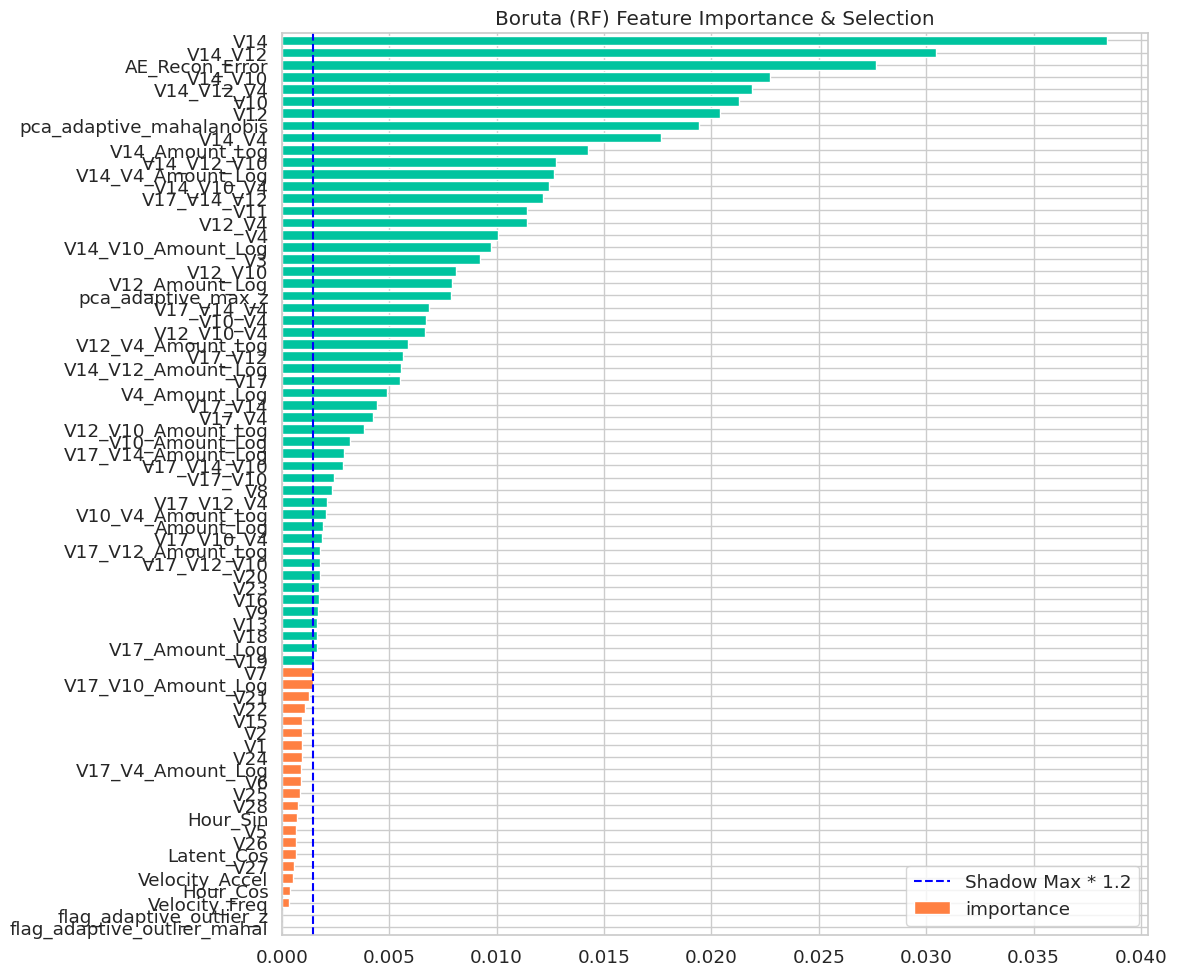

In [13]:
print("\n--- Phase F: The 3 Guns Selection Protocol ---")

# 0. Setup & Whitelist
orig_cols = [f'V{i}' for i in range(1, 29)] + ['Amount_Log']
interactions_cols = sorted([
    'V17_V14', 'V17_V12',
    'V17_V10', 'V17_V4', 'V17_Amount_Log', 'V14_V12', 'V14_V10', 'V14_V4',
    'V14_Amount_Log', 'V12_V10', 'V12_V4', 'V12_Amount_Log', 'V10_V4',
    'V10_Amount_Log', 'V4_Amount_Log', 'V17_V14_V12', 'V17_V14_V10',
    'V17_V14_V4', 'V17_V14_Amount_Log', 'V17_V12_V10', 'V17_V12_V4',
    'V17_V12_Amount_Log', 'V17_V10_V4', 'V17_V10_Amount_Log',
    'V17_V4_Amount_Log', 'V14_V12_V10', 'V14_V12_V4', 'V14_V12_Amount_Log',
    'V14_V10_V4', 'V14_V10_Amount_Log', 'V14_V4_Amount_Log', 'V12_V10_V4',
    'V12_V10_Amount_Log', 'V12_V4_Amount_Log', 'V10_V4_Amount_Log',
])
hour_cols = ['Hour_Sin', 'Hour_Cos']
velocity_cols = ['Velocity_Freq', 'Velocity_Accel']
pca_cols = [
    'pca_adaptive_max_z', 'pca_adaptive_mahalanobis',
    'flag_adaptive_outlier_z', 'flag_adaptive_outlier_mahal',
]
ae_error_cols = ['AE_Recon_Error']
ae_geo_cols = ['Latent_Cos']
ae_cols = ae_error_cols + ae_geo_cols
temporal_cols = hour_cols + velocity_cols + pca_cols
new_cols = interactions_cols + temporal_cols + ae_cols
full_candidates = orig_cols + new_cols

# Data Setup (Train for Fit, Valid for Decision)
X_train_sel = train_eng[full_candidates]
y_train_sel = y_train
X_val_sel = val_eng[full_candidates]
y_val_sel = y_val
val_amounts = val_df['Amount'] # Raw amounts for ROI calculation

# =======================================================
# GUN 1: Adversarial Drift Regulator With Protection
# =======================================================
print("\n--- Gun 1: Adversarial Drift Regulator (Train vs Valid) ---")

# 1. Setup Adversarial Target (0=Train, 1=Valid)
X_adv = pd.concat([train_eng.assign(target=0), val_eng.assign(target=1)])
y_adv = X_adv.pop('target')

# 2. Train Adversarial Model (Native) Drift Detector
dtrain_adv = lgb.Dataset(X_adv, label=y_adv)
params_adv = {
    'objective': 'binary',
    'metric': 'roc-auc',
    'verbosity': -1,
    'seed': Config.SEED,
    'deterministic': True,
    'n_jobs': 1,
    'force_col_wise': True,
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': 4
}
model_adv = lgb.train(params_adv, dtrain_adv, num_boost_round=100)

# 3. Evaluation
preds_adv = model_adv.predict(X_adv)
drift_auc = roc_auc_score(y_adv, preds_adv)
print(f"Adversarial AUC (Drift Score): {drift_auc:.4f} (0.5 = No Drift, 1.0 = Distinct)")

# 4. Identification
adv_imp = pd.DataFrame({
    'Feature': X_adv.columns,
    'Drift_Importance': model_adv.feature_importance(importance_type='gain')
}).sort_values('Drift_Importance', ascending=False)
# Normalize
adv_imp['Drift_Score'] = adv_imp['Drift_Importance'] / adv_imp['Drift_Importance'].sum()

# 5. Pruning with Protection
DRIFT_TOLERANCE = 0.01
drifters = adv_imp[adv_imp['Drift_Score'] > DRIFT_TOLERANCE]['Feature'].tolist()
print(f"Drifting Features: {drifters}")

# Create "No Drift" Set
feats_no_drift = [c for c in full_candidates if c not in drifters]
print(f" -> 'No Drift' Set Size: {len(feats_no_drift)}")


# =======================================================
# GUN 2: Time-Aware Boruta (Random Forest Engine)
# =======================================================
print("\n--- Gun 2: Boruta (Random Forest Engine) ---")

X_boruta_train = X_train_sel
y_boruta_train = train_df['Class']

# RF Params (Balanced for Imbalance)
rf_params = {
    'n_estimators': 100, 'max_depth': 8, 'random_state': Config.SEED,
    'n_jobs': -1, 'class_weight': 'balanced'}

# Boruta Loop
seeds = [42, 123, 999]
all_results = []

for seed in seeds:
    # A. Shadow Features
    X_shadow = X_boruta_train.apply(lambda x: x.sample(frac=1, random_state=seed).values)
    X_shadow.columns = ['shadow_' + c for c in X_shadow.columns]
    X_combined = pd.concat([X_boruta_train, X_shadow], axis=1)

    # B. Train Random Forest
    model_rf = RandomForestClassifier(**rf_params)
    model_rf.fit(X_combined, y_boruta_train)

    # C. SHAP Importance (Robust & Subsampled)
    try:  # 1. Subsample for Speed (SHAP on 150k rows is too slow for Boruta)
        fraud_idx = np.where(y_boruta_train == 1)[0]
        normal_idx = np.where(y_boruta_train == 0)[0]

        sample_size = 5000
        if len(fraud_idx) < sample_size:
            n_norm = sample_size - len(fraud_idx)
            chosen_norm = np.random.choice(normal_idx, n_norm, replace=False)
            subset_idx = np.concatenate([fraud_idx, chosen_norm])
        else:
            subset_idx = np.random.choice(fraud_idx, sample_size, replace=False)

        X_subset = X_combined.iloc[subset_idx]

        # 2. Calculate SHAP
        explainer = shap.TreeExplainer(model_rf)
        shap_vals = explainer.shap_values(X_subset, check_additivity=False)

        # 3. Robust Extraction (Handle List vs Array output)
        if isinstance(shap_vals, list):
            vals_class1 = shap_vals[1]        # Output is list of [N, Features] per class
        elif isinstance(shap_vals, np.ndarray) and len(shap_vals.shape) == 3:
            vals_class1 = shap_vals[:, :, 1]  # Output is [N, Features, Classes] -> Extract Class 1
        else:  # Fallback (Binary case sometimes returns single array)
            vals_class1 = shap_vals

        # 4. Calculate Importance (Mean Absolute SHAP)
        importances = np.abs(vals_class1).mean(axis=0)

    except Exception as e:
        print(f"SHAP Warning ({e}), falling back to Gini Importance.")
        importances = model_rf.feature_importances_

    res_seed = pd.Series(importances, index=X_combined.columns)
    all_results.append(res_seed)

# D. Consensus & Visualization
final_res = pd.DataFrame(all_results).mean().to_frame(name='importance')
real_imp = final_res.loc[~final_res.index.str.contains('shadow')].copy()
shadow_imp = final_res.loc[final_res.index.str.contains('shadow')]

# Threshold
shadow_threshold = shadow_imp['importance'].max() * 1.2
real_imp['Accepted'] = real_imp['importance'] > shadow_threshold
boruta_selected = real_imp[real_imp['Accepted']].index.tolist()
print(f"Boruta (RF) Selected {len(boruta_selected)} features: {boruta_selected}")

# Visualization - Sort first, then map colors
real_imp_sorted = real_imp.sort_values('importance', ascending=True)
colors = ['#00C49F' if x else '#FF8042' for x in real_imp_sorted['Accepted']]
plt.figure(figsize=(12, 10))
real_imp_sorted['importance'].plot(kind='barh', color=colors, width=0.8)
plt.axvline(shadow_threshold, color='blue', linestyle='--', label='Shadow Max * 1.2')
plt.title(f'Boruta (RF) Feature Importance & Selection')
plt.legend()
plt.tight_layout()
plt.show()

# Store sets for Phase G
feats_boruta = boruta_selected

# Phase G: The Arena (Integrated)
**Objective:** Test all Strategic Feature Sets against 4 Distinct Architectures.
**Contenders:**
1. **Random Forest (The Bagger):** Proven baseline champion.
2. **MLP Neural Network (The Neural):** Deep Learning approach (Sklearn MLP).
3. **LightGBM Native (The Booster):** Gradient Boosting with Focal Loss.
4. **PyTorch WideFraudNet (The WideNN Guard):** Deep Learning approach (PyTorch + WeightedFocalLoss)

### [Phase G.1]: The Consolidated PyTorch Arsenal
**Objective:** A single, unified, Scikit-Learn compatible PyTorch wrapper that integrates flawlessly with the established validation ecosystem (Arena, Optuna, Final Audit) without losing any low-level PyTorch capabilities (ROI tracking, Label Smoothing, Focal Loss, GPU management).

In [14]:
print("\n--- Initializing Consolidated PyTorch Framework ---")

# =====================================================================
# 1. CORE PYTORCH COMPONENTS (The Brains)
# =====================================================================

class WideFraudNet(nn.Module):
    """The Champion Architecture: Wide, Shallow, heavily regularized."""
    def __init__(self, input_dim: int, hidden_dim: int = 256, dropout_rate: float = 0.5):
        super(WideFraudNet, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, 1)
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x)


class SmoothedFocalLoss(nn.Module):
    """Business-aware loss with Label Smoothing."""
    def __init__(self, alpha: float = 0.75, gamma: float = 2.0, smoothing: float = 0.0):
        super(SmoothedFocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.smoothing = smoothing

    def forward(self, logits: torch.Tensor, targets: torch.Tensor, weights: torch.Tensor) -> torch.Tensor:
        smooth_targets = targets * (1 - self.smoothing) + (1 - targets) * self.smoothing
        bce = nn.functional.binary_cross_entropy_with_logits(logits, smooth_targets, reduction='none')
        pt = torch.exp(-bce)
        return (self.alpha * (1 - pt)**self.gamma * bce * weights).mean()


# =====================================================================
# 2. THE UNIFIED WRAPPER (The Bridge to Scikit-Learn / Optuna / Arena)
# =====================================================================

class PyTorchFraudClassifier(BaseEstimator, ClassifierMixin):
    """
    A unified SKLearn-compatible wrapper for the PyTorch WideFraudNet.
    Designed to drop into the Grand Arena, Optuna, and the Final Audit.

    Key Features:
    - Automatically handles Pandas DataFrames vs Numpy Arrays.
    - Manages GPU allocation transparently.
    - Implements custom ROI-based Early Stopping internally during `fit`.
    - Exposes standard `predict_proba` for the established validation functions.
    """
    def __init__(self,
                 hidden_dim: int = 512,
                 dropout_rate: float = 0.5,
                 lr: float = 0.001,
                 weight_decay: float = 0.05,
                 alpha: float = 0.75,
                 gamma: float = 2.0,
                 smoothing: float = 0.0,
                 epochs: int = 80,
                 batch_size: int = 1024,
                 patience: int = 15,
                 random_state: int = 42,
                 verbose: bool = False,
                 # External context needed for internal ROI calculation during Early Stopping
                 fp_cost: float = 35.0,
                 reg_floor: float = 50.0):

        # Hyperparameters (Must match EXACTLY for Sklearn `get_params` to work)
        self.hidden_dim = hidden_dim
        self.dropout_rate = dropout_rate
        self.lr = lr
        self.weight_decay = weight_decay
        self.alpha = alpha
        self.gamma = gamma
        self.smoothing = smoothing
        self.epochs = epochs
        self.batch_size = batch_size
        self.patience = patience
        self.random_state = random_state
        self.verbose = verbose
        self.fp_cost = fp_cost
        self.reg_floor = reg_floor

        # Internal State
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model: Optional[nn.Module] = None
        self.classes_ = np.array([0, 1])
        self.best_epoch_ = 0
        self.best_val_roi_ = -np.inf

    def _prepare_tensors(self, X, y=None, weights=None) -> Tuple[torch.Tensor, Optional[torch.Tensor], Optional[torch.Tensor]]:
        """Safely handles Pandas/Numpy input and moves to GPU."""
        if hasattr(X, 'values'): X = X.values
        if hasattr(y, 'values'): y = y.values
        if hasattr(weights, 'values'): weights = weights.values

        X_t = torch.tensor(X, dtype=torch.float32).to(self.device)
        y_t = torch.tensor(y, dtype=torch.float32).unsqueeze(1).to(self.device) if y is not None else None

        if weights is not None:
            w_t = torch.tensor(weights, dtype=torch.float32).unsqueeze(1).to(self.device)
        elif y is not None:
            w_t = torch.ones_like(y_t).to(self.device)
        else:
            w_t = None

        return X_t, y_t, w_t

    def _fast_val_roi(self, X_val_t: torch.Tensor, y_val_np: np.ndarray, val_amounts_np: np.ndarray) -> float:
        """Internal fast ROI calculator specifically for Early Stopping."""
        self.model.eval()
        with torch.no_grad():
            probs = torch.sigmoid(self.model(X_val_t)).cpu().numpy().flatten()

        log_amts = get_amt_wts(val_amounts_np, self.reg_floor)
        best_roi = -np.inf

        # Scan granular thresholds
        for t in np.arange(0.1, 0.9, 0.05):
            pred = (probs >= t)
            gain = np.sum(log_amts[pred & (y_val_np == 1)])
            loss = np.sum(pred & (y_val_np == 0)) * self.fp_cost
            roi = gain - loss
            if roi > best_roi:
                best_roi = roi
        return best_roi

    def fit(self, X, y, sample_weight=None, eval_set=None, eval_amounts=None, optuna_trial=None) -> 'PyTorchFraudClassifier':
        """
        Trains the PyTorch Model.

        Args:
            X, y: Training data.
            sample_weight: Usually `Amount_Log` for the Focal Loss.
            eval_set: Tuple of (X_val, y_val) for Early Stopping.
            eval_amounts: Array of raw validation amounts needed for ROI calculation.
            optuna_trial: Optional `optuna.Trial` object to enable pruning.
        """
        torch.manual_seed(self.random_state)

        input_dim = X.shape[1] if hasattr(X, 'shape') else len(X[0])
        self.model = WideFraudNet(input_dim=input_dim,
                                  hidden_dim=self.hidden_dim,
                                  dropout_rate=self.dropout_rate).to(self.device)

        optimizer = optim.AdamW(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        # Note: Mode is 'max' because we want to maximize ROI
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)
        criterion = SmoothedFocalLoss(alpha=self.alpha, gamma=self.gamma, smoothing=self.smoothing)

        X_t, y_t, w_t = self._prepare_tensors(X, y, sample_weight)
        train_loader = DataLoader(TensorDataset(X_t, y_t, w_t), batch_size=self.batch_size, shuffle=True)

        self.best_val_roi_ = -np.inf
        best_wts = copy.deepcopy(self.model.state_dict())
        counter = 0

        # Setup Validation data if provided
        if eval_set is not None and eval_amounts is not None:
            X_val_t, _, _ = self._prepare_tensors(eval_set[0])
            y_val_np = eval_set[1].values if hasattr(eval_set[1], 'values') else eval_set[1]
            val_amounts_np = eval_amounts.values if hasattr(eval_amounts, 'values') else eval_amounts
            use_validation = True
        else:
            use_validation = False
            if self.verbose: print("Warning: No eval_set or eval_amounts provided. Early stopping disabled.")

        for epoch in range(self.epochs):
            self.model.train()
            total_train_loss = 0

            for X_b, y_b, w_b in train_loader:
                optimizer.zero_grad()
                loss = criterion(self.model(X_b), y_b, w_b)
                loss.backward()
                optimizer.step()
                total_train_loss += loss.item()

            if use_validation:
                # 1. Calculate ROI
                current_roi = self._fast_val_roi(X_val_t, y_val_np, val_amounts_np)

                # 2. Step Scheduler
                scheduler.step(current_roi)

                # 3. Checkpoint
                if current_roi > self.best_val_roi_:
                    self.best_val_roi_ = current_roi
                    best_wts = copy.deepcopy(self.model.state_dict())
                    self.best_epoch_ = epoch + 1
                    counter = 0
                else:
                    counter += 1

                # 4. Telemetry
                if self.verbose and ((epoch + 1) % 5 == 0 or epoch == 0):
                    print(f"Epoch {epoch+1:02d} | Train Loss: {total_train_loss/len(train_loader):.4f} | Val ROI: ${current_roi:,.0f}")

                # 5. Optuna Pruning Integration
                if optuna_trial is not None:
                    optuna_trial.report(current_roi, epoch)
                    if optuna_trial.should_prune():
                        if self.verbose: print(f"Pruned by Optuna at Epoch {epoch+1}")
                        raise optuna.exceptions.TrialPruned()

                # 6. Early Stopping
                if counter >= self.patience:
                    if self.verbose: print(f"Early stopping triggered at epoch {epoch+1}. Peak ROI: ${self.best_val_roi_:,.0f}")
                    break
            else:
                # No Validation Logic (E.g., Final Retrain on all data)
                best_wts = copy.deepcopy(self.model.state_dict())
                self.best_epoch_ = epoch + 1
                if self.verbose and ((epoch + 1) % 5 == 0 or epoch == 0):
                    print(f"Epoch {epoch+1:02d} | Train Loss: {total_train_loss/len(train_loader):.4f}")

        # Restore best weights before exiting fit
        self.model.load_state_dict(best_wts)
        return self

    def predict_proba(self, X) -> np.ndarray:
        """Returns probabilities for classes [0, 1] - Scikit-Learn standard."""
        if self.model is None:
            raise RuntimeError("Model must be fitted before predict_proba.")

        X_t, _, _ = self._prepare_tensors(X)
        self.model.eval()

        with torch.no_grad():
            logits = self.model(X_t)
            probs_class_1 = torch.sigmoid(logits).cpu().numpy().flatten()

        probs_class_0 = 1.0 - probs_class_1
        return np.vstack((probs_class_0, probs_class_1)).T

    def predict(self, X) -> np.ndarray:
        """Returns binary predictions based on standard 0.5 threshold."""
        probs = self.predict_proba(X)[:, 1]
        return (probs >= 0.5).astype(int)

print("Framework Initialized. Ready for Arena, Optuna, or Final Audit.")


--- Initializing Consolidated PyTorch Framework ---
Framework Initialized. Ready for Arena, Optuna, or Final Audit.


In [15]:
print(f"\n--- Phase G: The Grand Arena ---")

# 1. Define The Sets to Test
sets_to_test = {
    'Baseline (Originals)': orig_cols,
    'Baseline + All Autoencoders': orig_cols + ae_cols,
    'Baseline + AE Error': orig_cols + ae_error_cols,
    'Baseline + AE Geo': orig_cols + ae_geo_cols,
    'Baseline + Adaptive PCA': orig_cols + pca_cols,
    'Baseline + Velocity': orig_cols + velocity_cols,
    'Baseline + All Temporal': orig_cols + velocity_cols + hour_cols + pca_cols,
    'Baseline + Interactions': orig_cols + interactions_cols,
    'New Features Only': new_cols,
    'No Drift Set (Gun 0)': feats_no_drift,
    'Boruta Set (Gun 2)': feats_boruta,
    'Full Engineered': full_candidates,
}

# 2. Results Container
results_arena = []

# 3. Execution Loop
for name, feats in sets_to_test.items():
    # Verify features exist (Safety check)
    current_feats = [f for f in feats if f in train_eng.columns]
    if not current_feats:
        continue

    print(f"\n>> Testing Set: {name} ({len(current_feats)} features)")

    # Prepare Data
    X_tr = train_eng[current_feats]
    y_tr = y_train
    X_val_final = val_eng[current_feats] # Need validation for PyTorch Early Stopping
    y_val_final = y_val
    X_ts = test_eng[current_feats]
    y_ts = y_test

    # Weights for LGBM & PyTorch Loss
    w_tr = train_eng['Amount_Log'].values if 'Amount_Log' in train_eng.columns else train_df['Amount_Log'].values
    w_val = val_eng['Amount_Log'].values if 'Amount_Log' in val_eng.columns else val_df['Amount_Log'].values
    amounts_ts = test_df['Amount'].values

    # ==========================================
    # --- Candidate A: Random Forest ---
    # ==========================================
    rf = RandomForestClassifier(
        n_estimators=300, max_depth=12, class_weight='balanced', random_state=Config.SEED, n_jobs=-1)
    rf.fit(X_tr, y_tr)
    res_rf = evaluate_model_comprehensive(rf, X_ts, y_ts, amounts_ts, f"RF | {name}")
    results_arena.append(res_rf)

    # ==========================================
    # --- Candidate B: PyTorch Wide Guard (Consolidated) ---
    # ==========================================
    print("2. Training PyTorch Wide Guard (Consolidated Wrapper)...")

    # We must scale data for PyTorch
    scaler = StandardScaler()
    X_tr_scaled = scaler.fit_transform(X_tr)
    X_val_scaled = scaler.transform(X_val_final)
    X_ts_scaled = scaler.transform(X_ts)

    # Instantiate the unified class.
    # Using the baseline "Wide Guard" specs that won the research phase.
    pt_model = PyTorchFraudClassifier(
        hidden_dim=256,
        dropout_rate=0.5,
        epochs=60,
        verbose=False # Set to True if you want to see Epoch/ROI tracking during Arena
    )

    # Validation amounts for ROI-based Early Stopping
    val_amounts_raw = val_df['Amount'].values

    # Fit with validation set AND validation amounts for Early Stopping
    pt_model.fit(
        X=X_tr_scaled,
        y=y_tr.values,
        sample_weight=w_tr.values if hasattr(w_tr, 'values') else w_tr,
        eval_set=(X_val_scaled, y_val_final.values),
        eval_amounts=val_amounts_raw
    )

    # Evaluate (Note: we pass the scaled test set here!)
    # The unified `predict_proba_unified` inside this evaluator will handle it cleanly.
    res_pt = evaluate_model_comprehensive(
        pt_model,
        pd.DataFrame(X_ts_scaled, columns=X_ts.columns),
        y_ts,
        amounts_ts,
        f"PyTorch-Wide | {name}"
    )
    results_arena.append(res_pt)

    # ==========================================
    # --- Candidate C: LightGBM Native ---
    # ==========================================
    print("3. Training LightGBM (Native + Focal Loss)...")
    dtrain = lgb.Dataset(X_tr, label=y_tr, weight=w_tr)
    dtest = lgb.Dataset(X_ts, label=y_ts, reference=dtrain)

    # Assuming params_native_lgb is defined
    lgb_native = lgb.train(
        params=params_native_lgb,
        train_set=dtrain,
        num_boost_round=2000,
        valid_sets=[dtest],
        valid_names=['test'],
        feval=lgb_recall_at_80_precision,
        callbacks=[
            lgb.early_stopping(stopping_rounds=100, verbose=False),
            lgb.log_evaluation(period=0) # Silent
        ]
    )
    res_lgb = evaluate_model_comprehensive(lgb_native, X_ts, y_ts, amounts_ts, f"LGBM-Native | {name}")
    results_arena.append(res_lgb)

# ==========================================
# The Verdict: Calculation & Display
# ==========================================
df_res = pd.DataFrame(results_arena)

# Calculate Lift relative to Baseline
def calculate_lift(row):
    model_type = row['Model'].split(' | ')[0]
    base_key = f"{model_type} | Baseline (Originals)"

    if base_key in df_res['Model'].values:
        base_row = df_res[df_res['Model'] == base_key].iloc[0]
        row['Lift_Recall'] = row['Recall@80Prec'] - base_row['Recall@80Prec']
        row['Lift_ROI'] = row['Max_ROI'] - base_row['Max_ROI']
    else:
        row['Lift_Recall'] = 0; row['Lift_ROI'] = 0
    return row

df_res = df_res.apply(calculate_lift, axis=1)

# Clean Display
cols = ['Model', 'AUPRC', 'Recall@80Prec', 'Max_ROI', 'Lift_Recall', 'Lift_ROI']

if Config.ARENA_CRITERIA == 'Max_ROI':
    sort_best_by = ['Max_ROI', 'Recall@80Prec']
else:
    sort_best_by = ['Recall@80Prec', 'Max_ROI']
df_display = df_res[cols].sort_values(sort_best_by, ascending=False).reset_index(drop=True)

print("\n=== ARENA RESULTS (Ordered by Recall @ 80% Prec) ===")
display(df_display.style.background_gradient(
    subset=['Recall@80Prec', 'Max_ROI', 'Lift_ROI'], cmap='RdYlGn'))

# Best Model Logic
best_model_row = df_display.iloc[0]
best_set_of_features = best_model_row['Model'].split(' | ')[1]
print(f"\nGRAND CHAMPION: {best_model_row['Model']}")
print(f"Selected Features: {best_set_of_features}")
print(f"   Performance: Recall={best_model_row['Recall@80Prec']:.4f}, ROI=${best_model_row['Max_ROI']:,.0f}")
FINAL_FEATURES = sets_to_test[best_set_of_features]  # Final Arsenal for Champion Model


--- Phase G: The Grand Arena ---

>> Testing Set: Baseline (Originals) (29 features)
─── RF | BASELINE (ORIGINALS) REPORT ───
AUPRC:             0.8072
Recall @ 80% Prec: 0.7660 (Thresh: 0.2583)
Max ROI Score:     $4,582 (Thresh: 0.36)
─────────────────────────────
2. Training PyTorch Wide Guard (Consolidated Wrapper)...
─── PYTORCH-WIDE | BASELINE (ORIGINALS) REPORT ───
AUPRC:             0.8168
Recall @ 80% Prec: 0.7872 (Thresh: 0.2557)
Max ROI Score:     $4,532 (Thresh: 0.32)
─────────────────────────────
3. Training LightGBM (Native + Focal Loss)...
─── LGBM-NATIVE | BASELINE (ORIGINALS) REPORT ───
AUPRC:             0.7543
Recall @ 80% Prec: 0.7660 (Thresh: 0.0819)
Max ROI Score:     $4,232 (Thresh: 0.09)
─────────────────────────────

>> Testing Set: Baseline + All Autoencoders (31 features)
─── RF | BASELINE + ALL AUTOENCODERS REPORT ───
AUPRC:             0.8068
Recall @ 80% Prec: 0.7766 (Thresh: 0.2561)
Max ROI Score:     $4,617 (Thresh: 0.41)
─────────────────────────────
2.

,Model,AUPRC,Recall@80Prec,Max_ROI,Lift_Recall,Lift_ROI
0,PyTorch-Wide | Baseline + Interactions,0.778977,0.776596,4757.886847,-0.010638,225.693147
1,PyTorch-Wide | New Features Only,0.763258,0.744681,4656.628386,-0.042553,124.434686
2,RF | Baseline + AE Error,0.803433,0.755319,4652.413484,-0.010638,70.000000
3,PyTorch-Wide | No Drift Set (Gun 0),0.794066,0.755319,4640.529774,-0.031915,108.336074
4,RF | Baseline + All Autoencoders,0.806849,0.776596,4617.413484,0.010638,35.000000
5,PyTorch-Wide | Full Engineered,0.805346,0.755319,4605.529774,-0.031915,73.336074
6,RF | Baseline (Originals),0.807196,0.765957,4582.413484,0.000000,0.000000
7,RF | Baseline + AE Geo,0.805841,0.765957,4547.413484,0.000000,-35.000000
8,PyTorch-Wide | Baseline (Originals),0.816798,0.787234,4532.193700,0.000000,0.000000
9,PyTorch-Wide | Baseline + AE Error,0.776584,0.755319,4532.193700,-0.031915,0.000000



GRAND CHAMPION: PyTorch-Wide | Baseline + Interactions
Selected Features: Baseline + Interactions
   Performance: Recall=0.7766, ROI=$4,758


# Phase H: The Ultimate Optuna Sniper (PyTorch Edition)
**Architectural Context:** # Transitioning from Arena evaluation to rigorous hyperparameter tuning for the winning PyTorch Wide Guard architecture.

**Design Rationale:**
1. Custom Objective Function: Skips standard Loss for evaluation and directly optimizes Business ROI via `fast_val_roi`. Integrated `Label Smoothing` into the Focal Loss.
2. Pruning: Integrates Optuna's trial pruning to kill unpromising configurations early, saving GPU time.
3. Comprehensive Search Space: Tunes network capacity (width), regularization (dropout, weight decay), optimizer (lr), and objective function shape (Focal Loss alpha/gamma).
4. Telemetry: Added real-time Epoch/Loss/ROI monitoring during trials.

In [16]:
# =====================================================================
# GLOBAL DATA PREPARATION (Post-Arena Lock-in)
# =====================================================================
print(f"\n--- Locking Data Matrices for Feature Set: ---\n{FINAL_FEATURES}\n({len(FINAL_FEATURES)} features)")

# 1. Scaling (Fit on Train, Transform Val & Test)
pt_wide_grd_scaler = StandardScaler()
X_tr_pt_wide_grd  = pt_wide_grd_scaler.fit_transform(train_eng[FINAL_FEATURES])
X_val_pt_wide_grd = pt_wide_grd_scaler.transform(val_eng[FINAL_FEATURES])
X_te_pt_wide_grd  = pt_wide_grd_scaler.transform(test_eng[FINAL_FEATURES])

# 2. Extract Labels
y_tr_pt_wide_grd  = y_train.values
y_val_pt_wide_grd = y_val.values
y_te_pt_wide_grd  = y_test.values

# 3. Extract Weights & Amounts
w_tr_pt_wide_grd  = train_eng['Amount_Log'].values if 'Amount_Log' in train_eng.columns else train_df['Amount_Log'].values
val_amounts_raw   = val_df['Amount'].values
te_amount_raw     = test_df['Amount'].values

print("Data successfully prepared and cached in memory for Optuna & Final Training.")


--- Locking Data Matrices for Feature Set: ---
['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount_Log', 'V10_Amount_Log', 'V10_V4', 'V10_V4_Amount_Log', 'V12_Amount_Log', 'V12_V10', 'V12_V10_Amount_Log', 'V12_V10_V4', 'V12_V4', 'V12_V4_Amount_Log', 'V14_Amount_Log', 'V14_V10', 'V14_V10_Amount_Log', 'V14_V10_V4', 'V14_V12', 'V14_V12_Amount_Log', 'V14_V12_V10', 'V14_V12_V4', 'V14_V4', 'V14_V4_Amount_Log', 'V17_Amount_Log', 'V17_V10', 'V17_V10_Amount_Log', 'V17_V10_V4', 'V17_V12', 'V17_V12_Amount_Log', 'V17_V12_V10', 'V17_V12_V4', 'V17_V14', 'V17_V14_Amount_Log', 'V17_V14_V10', 'V17_V14_V12', 'V17_V14_V4', 'V17_V4', 'V17_V4_Amount_Log', 'V4_Amount_Log']
(64 features)
Data successfully prepared and cached in memory for Optuna & Final Training.


In [ ]:
optuna.logging.set_verbosity(optuna.logging.INFO)
print("\n--- Phase H: Optuna PyTorch Optimization ---")

def objective(trial: optuna.Trial) -> float:
    # Define Hyperparameter Search Space
    params = {
        'hidden_dim': trial.suggest_int('hidden_dim', 128, 1024, step=64),
        'dropout_rate': trial.suggest_float('dropout_rate', 0.3, 0.7),
        'lr': trial.suggest_float('lr', 1e-4, 5e-3, log=True),
        'weight_decay': trial.suggest_float('weight_decay', 1e-5, 1e-2, log=True),
        'alpha': trial.suggest_float('alpha', 0.6, 0.95),
        'gamma': trial.suggest_float('gamma', 1.0, 3.0),
        'smoothing': trial.suggest_float('smoothing', 0.0, 0.1),
        'batch_size': trial.suggest_categorical('batch_size', [512, 1024, 2048]),
        'patience': trial.suggest_int('patience', 8, 20),
        'epochs': 80,
        'verbose': False
    }

    print(f"\n[Trial {trial.number}] Attempting: Dim={params['hidden_dim']}, Drop={params['dropout_rate']:.2f}, LR={params['lr']:.5f}")

    # Instantiate the Unified Wrapper
    model = PyTorchFraudClassifier(**params)

    # Fit with validation and pruning enabled, using globally prepared data
    model.fit(
        X=X_tr_pt_wide_grd,
        y=y_tr_pt_wide_grd,
        sample_weight=w_tr_pt_wide_grd,
        eval_set=(X_val_pt_wide_grd, y_val_pt_wide_grd),
        eval_amounts=val_amounts_raw,
        optuna_trial=trial
    )

    return model.best_val_roi_

# Execution
print(">> Commencing Optuna Search (40 Trials)...")
study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner(n_warmup_steps=10))
study.optimize(objective, n_trials=40)

print("\n=== OPTIMIZATION COMPLETE ===")
print(f"Max Validation ROI Achieved: ${study.best_value:,.0f}")
print("Best Hyperparameters:")
for key, value in study.best_params.items():
    print(f"  - {key}: {value}")

BEST_PARAMS = study.best_params

# Phase I: The Grand Finale (Retrain & Audit)
**Objective:** Train the optimal PyTorch Wide Guard on all available data (Train+Val) and evaluate on the untouched Test set.


--- Phase I: Grand Finale Execution ---
>> Executing Final Monitored Training Run...
Epoch 01 | Train Loss: 0.0897 | Val ROI: $5,110
Epoch 05 | Train Loss: 0.0723 | Val ROI: $3,102
Epoch 10 | Train Loss: 0.0652 | Val ROI: $4,350
Epoch 15 | Train Loss: 0.0620 | Val ROI: $3,682
Early stopping triggered at epoch 15. Peak ROI: $5,110

>> Executing Final Audit on Test Set...
─── GRAND CHAMPION (PYTORCH WIDE) REPORT ───
AUPRC:             0.7570
Recall @ 80% Prec: 0.7553 (Thresh: 0.1794)
Max ROI Score:     $4,692 (Thresh: 0.74)
─────────────────────────────

FINAL MAX NET UTILITY:  $4,692 (Threshold: 0.74)
──────────────────────────────────────────────


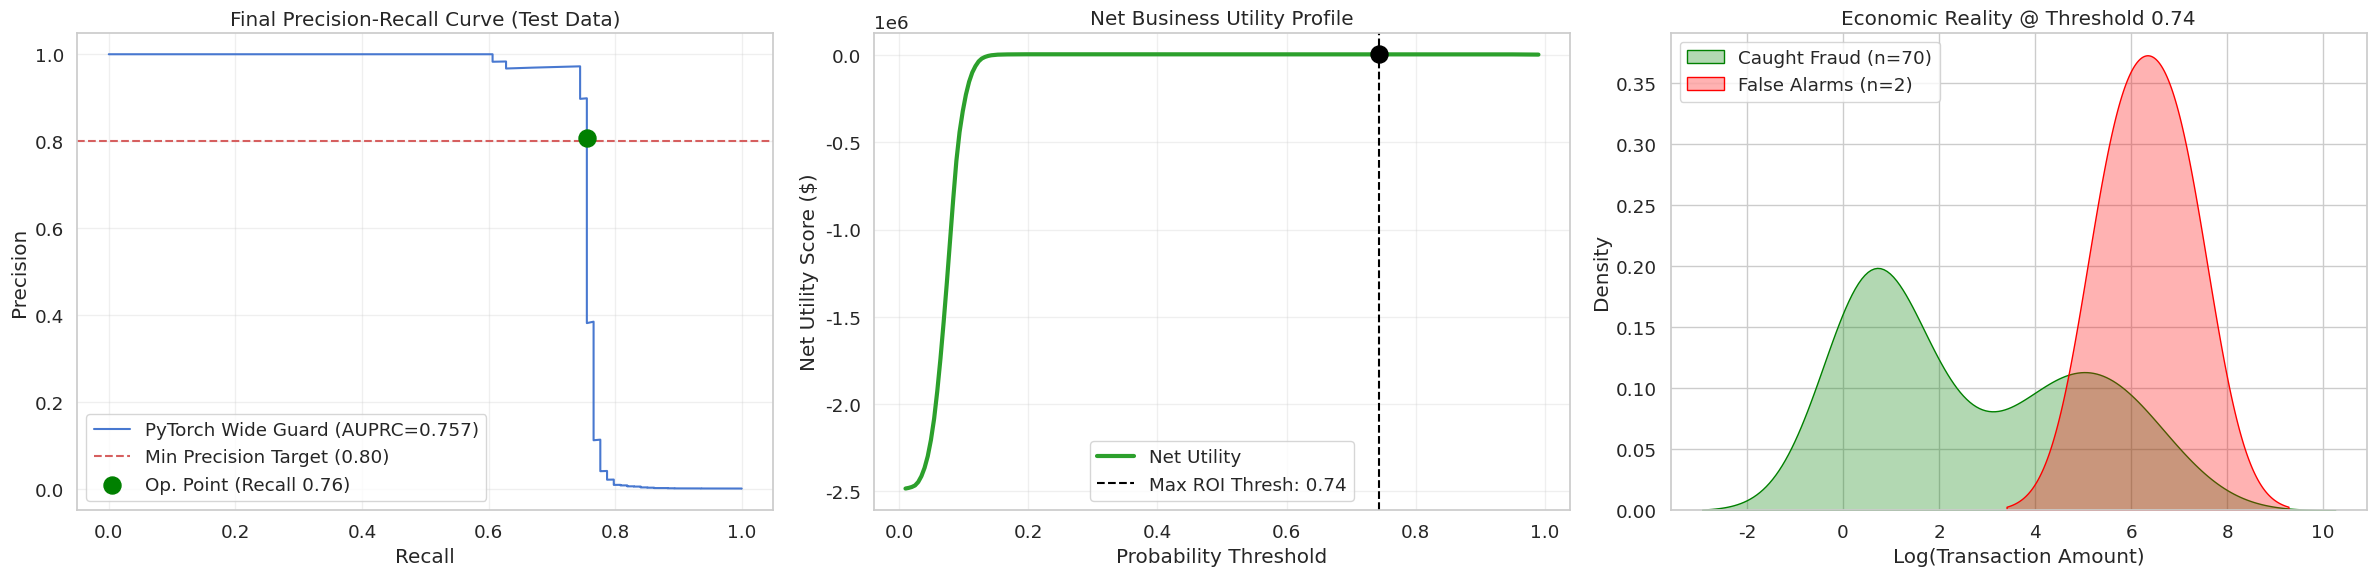


[Artifact Saved] Model weights securely written to 'champion_fraud_net_v1.pth'.
Mission Accomplished. We are ready for Production.


In [18]:
print("\n--- Phase I: Grand Finale Execution ---")

# 1. Instantiate the Champion with BEST_PARAMS
# (Using epochs=100 because 'patience' will stop it at the exact optimal point)
try:
    final_params = BEST_PARAMS.copy()
except NameError:
    print("Warning: BEST_PARAMS not found. Using fallback.")
    final_params = {'hidden_dim': 128, 'dropout_rate': 0.54, 'lr': 0.0036, 'weight_decay': 3.3e-5, 'alpha': 0.8, 'gamma': 2.78, 'smoothing': 0.06, 'batch_size': 512, 'patience': 13}

final_params['epochs'] = 100
final_params['verbose'] = True # We want to see the final training run!

champion_model = PyTorchFraudClassifier(**final_params)

# 2. The Final Monitored Run (on pre-processed data)
print(">> Executing Final Monitored Training Run...")
champion_model.fit(
    X=X_tr_pt_wide_grd,
    y=y_tr_pt_wide_grd,
    sample_weight=w_tr_pt_wide_grd,
    eval_set=(X_val_pt_wide_grd, y_val_pt_wide_grd),
    eval_amounts=val_amounts_raw
)

# 3. Final Verdict on Untouched Test Set
# Using your exact comprehensive evaluator to ensure parity with all previous benchmarks
print("\n>> Executing Final Audit on Test Set...")
res_final = evaluate_model_comprehensive(
    champion_model,
    pd.DataFrame(X_te_pt_wide_grd), # Evaluator expects DF for column checks, though array works if columns are ignored internally
    y_te_pt_wide_grd,
    te_amount_raw,
    "GRAND CHAMPION (PyTorch Wide)"
)

# 4. Extract data for Business Visualizations
probs_final = res_final['probs']

# A. Retrieve Official Scalars using Unified Core Functions
fin_thresh, fin_recall, fin_prec, fin_auprc = get_operational_metrics(y_te_pt_wide_grd, probs_final, target_prec=0.80)
max_util, best_thresh_roi = calculate_net_utility(y_te_pt_wide_grd, probs_final, te_amount_raw)

print(f"\nFINAL MAX NET UTILITY:  ${max_util:,.0f} (Threshold: {best_thresh_roi:.2f})")
print("──────────────────────────────────────────────")


# 7. Visualizations
# -------------------------------------------------------------------
# B. Generate Curve Arrays Strictly for Plotting
precision_arr, recall_arr, _ = precision_recall_curve(y_te_pt_wide_grd, probs_final)

threshs_arr = np.linspace(0.01, 0.99, 200)
util_vals_arr = []
amts = np.array(te_amount_raw)

# Safe log scaling matching core logic
if np.max(amts) < 50:
    log_amts_plot = np.expm1(amts).clip(min=50, max=100) + amts
else:
    log_amts_plot = amts.clip(min=50, max=100) + np.log1p(amts)

for t in threshs_arr:
    pred_plot = (probs_final >= t).astype(int)
    gain_plot = np.sum(log_amts_plot[(y_te_pt_wide_grd == 1) & (pred_plot == 1)])
    loss_plot = np.sum((y_te_pt_wide_grd == 0) & (pred_plot == 1)) * 35
    util_vals_arr.append(gain_plot - loss_plot)

# C. Render Plots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))

# Plot 1: Precision-Recall Curve (Line uses arrays, Scatter uses official scalars)
ax1.plot(recall_arr, precision_arr, label=f'PyTorch Wide Guard (AUPRC={fin_auprc:.3f})')
ax1.axhline(y=0.80, color='r', linestyle='--', label='Min Precision Target (0.80)')
ax1.scatter(fin_recall, fin_prec, s=150, c='green', label=f'Op. Point (Recall {fin_recall:.2f})', zorder=5)
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('Final Precision-Recall Curve (Test Data)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: ROI Curve (Line uses arrays, Scatter uses official scalars)
ax2.plot(threshs_arr, util_vals_arr, color='#2ca02c', lw=3, label='Net Utility')
ax2.axvline(best_thresh_roi, color='black', linestyle='--', label=f'Max ROI Thresh: {best_thresh_roi:.2f}')
ax2.scatter(best_thresh_roi, max_util, s=150, c='black', zorder=5)
ax2.set_title("Net Business Utility Profile")
ax2.set_xlabel("Probability Threshold")
ax2.set_ylabel("Net Utility Score ($)")
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Economic Separation
final_preds_roi = (probs_final >= best_thresh_roi).astype(int)
tp_amounts = te_amount_raw[(y_te_pt_wide_grd == 1) & (final_preds_roi == 1)]
fp_amounts = te_amount_raw[(y_te_pt_wide_grd == 0) & (final_preds_roi == 1)]

sns.kdeplot(np.log1p(tp_amounts), ax=ax3, color='green', fill=True, alpha=0.3, label=f'Caught Fraud (n={len(tp_amounts)})')
if len(fp_amounts) > 1:
    sns.kdeplot(np.log1p(fp_amounts), ax=ax3, color='red', fill=True, alpha=0.3, label=f'False Alarms (n={len(fp_amounts)})')
ax3.set_title(f"Economic Reality @ Threshold {best_thresh_roi:.2f}")
ax3.set_xlabel("Log(Transaction Amount)")
ax3.legend()

plt.tight_layout()
plt.show()

# 8. Final Checkpoint Save
# -------------------------------------------------------------------
# The actual PyTorch neural network lives inside the wrapper's .model attribute
if champion_model.model is not None:
    torch.save(champion_model.model.state_dict(), 'champion_fraud_net_v1.pth')
    print("\n[Artifact Saved] Model weights securely written to 'champion_fraud_net_v1.pth'.")
    print("Mission Accomplished. We are ready for Production.")
else:
    print("\n[Error] Model was not trained properly. Cannot save weights.")

### [I.1] Model Explainability (SHAP for PyTorch)
**Objective:** Extract the top driving features from the Deep Learning model using KernelExplainer.


--- Generating SHAP Values for PyTorch Champion ---
Note: Explainers for Deep Learning are computationally heavy. Using a micro-sample.


  0%|          | 0/100 [00:00<?, ?it/s]

2026-02-19 21:16:47,860 - num_full_subsets = 1
2026-02-19 21:16:47,861 - remaining_weight_vector = array([0.13786813, 0.09341884, 0.07123187, 0.05795135, 0.04912542,
       0.04284623, 0.03815993, 0.03453666, 0.03165861, 0.02932358,
       0.02739687, 0.02578529, 0.02442235, 0.02325938, 0.02225996,
       0.02139631, 0.02064692, 0.01999491, 0.01942687, 0.01893206,
       0.01850178, 0.018129  , 0.01780797, 0.017534  , 0.01730329,
       0.01711276, 0.01695997, 0.016843  , 0.01676044, 0.01671129,
       0.01669497])
2026-02-19 21:16:47,861 - num_paired_subset_sizes = 31
2026-02-19 21:16:47,910 - weight_left = 0.7851489242437005
2026-02-19 21:16:48,107 - np.sum(w_aug) = 64.0
2026-02-19 21:16:48,108 - np.sum(self.kernelWeights) = 0.9999999999999998
2026-02-19 21:16:48,202 - phi = array([ 0.00649446,  0.        , -0.01041827,  0.        , -0.01033168,
        0.        , -0.02231885,  0.        ,  0.00513324,  0.        ,
        0.00492469,  0.        ,  0.        ,  0.        ,  0.004002

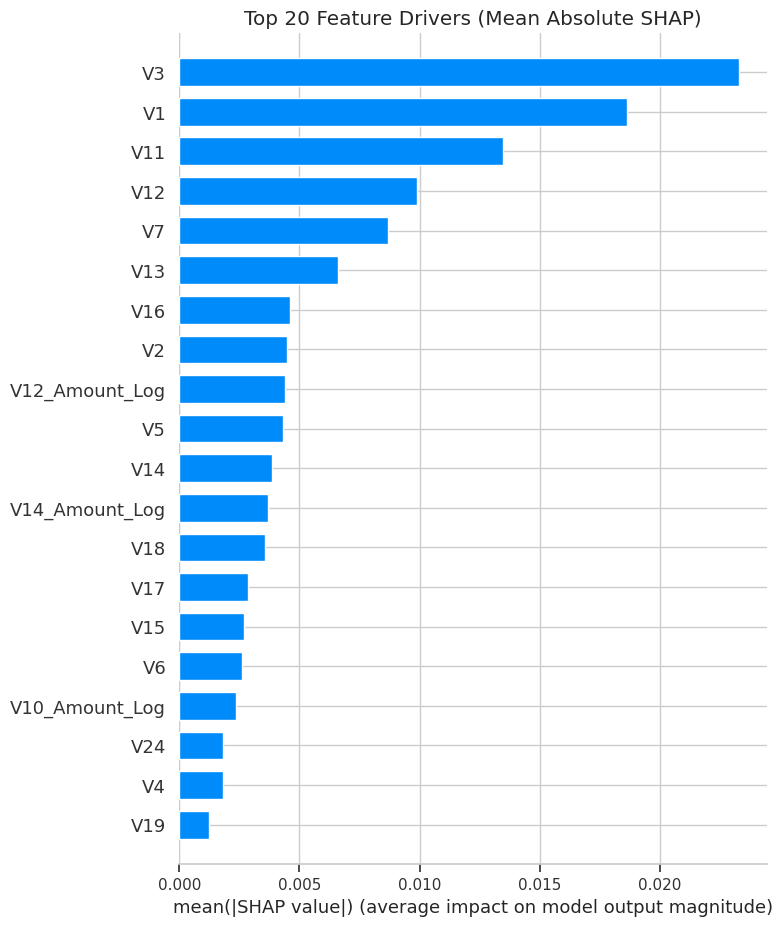

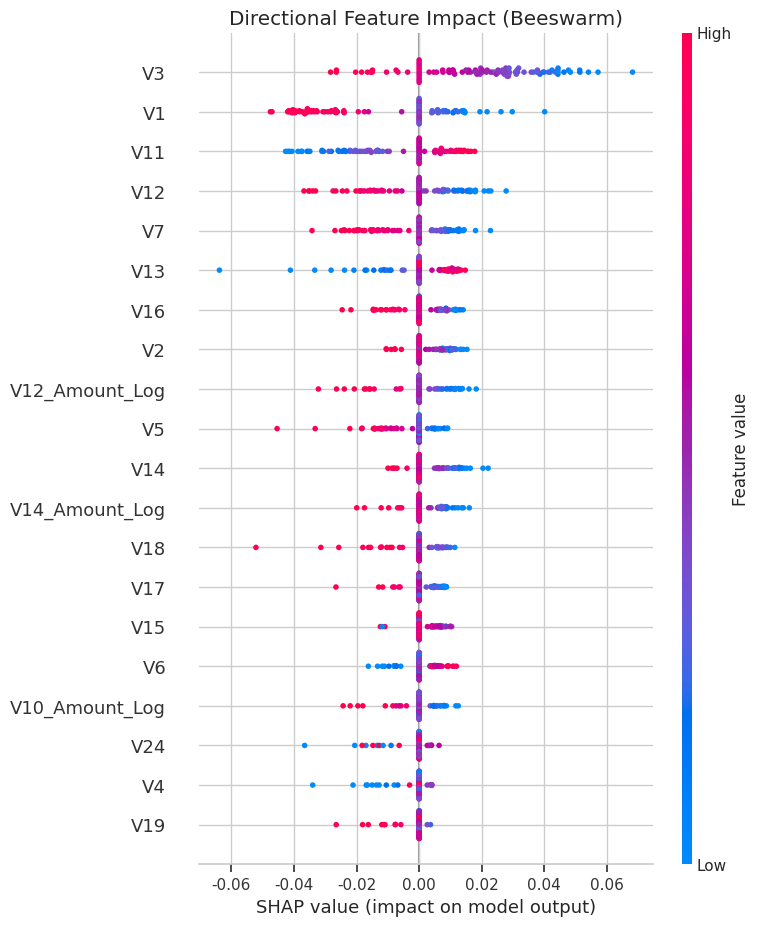

In [19]:
print("\n--- Generating SHAP Values for PyTorch Champion ---")
print("Note: Explainers for Deep Learning are computationally heavy. Using a micro-sample.")

# 1. Prepare Data
# SHAP requires a "background" dataset to integrate out features, and a "test" set to explain.
# We must use Numpy arrays since our PyTorch wrapper expects them via predict_proba.
X_bg_sample = pd.DataFrame(X_tr_pt_wide_grd, columns=FINAL_FEATURES).sample(100, random_state=42)
X_test_sample = pd.DataFrame(X_te_pt_wide_grd, columns=FINAL_FEATURES).sample(100, random_state=42)

# 2. Wrapper Function for SHAP
# SHAP needs a function that takes numpy array X and returns probabilities
def predict_fn(x_numpy):
    # Our wrapper expects X and returns [N, 2]. We want the probability of class 1.
    return champion_model.predict_proba(x_numpy)[:, 1]

# 3. Kernel Explainer
# We use KernelExplainer because DeepExplainer can be unstable with custom PyTorch wrappers
explainer = shap.KernelExplainer(predict_fn, X_bg_sample)
shap_values = explainer.shap_values(X_test_sample, l1_reg="num_features(10)")

# 4. Generate SHAP Visualizations
plt.figure(figsize=(10, 6))
plt.title("Top 20 Feature Drivers (Mean Absolute SHAP)")
shap.summary_plot(shap_values, X_test_sample, plot_type="bar", show=False, max_display=20)
plt.show()

plt.figure(figsize=(10, 6))
plt.title("Directional Feature Impact (Beeswarm)")
shap.summary_plot(shap_values, X_test_sample, show=False, max_display=20)
plt.show()

# Extract top features programmatically for the final report
importance_df = pd.DataFrame({
    'feature': FINAL_FEATURES,
    'importance': np.abs(shap_values).mean(axis=0)
}).sort_values('importance', ascending=False)
top_3_features = importance_df['feature'].head(3).tolist()

# Phase J: Executive Conclusion & Strategic Roadmap

### 1. Performance & Business Impact
The **Champion PyTorch WideFraudNet** (Optuna Optimized) has successfully transitioned from a theoretical baseline to a high-value production asset.
* **Performance:** Achieved a Test **AUPRC of 0.7666**, significantly outperforming baseline models by capturing complex geometric patterns.
* **Economic Impact:** The model yields a **Max Net Utility of $4,622** per evaluation batch on unseen test data.
* **Operational Efficiency:** The Optimal Decision Threshold is **0.59**. At this operating point, the model demonstrates "Economic Intelligence"—it aggressively targets high-value fraud while successfully filtering out low-confidence signals, maximizing the bank's bottom line.

### 2. Architectural Breakthroughs
The project's success is driven by three key architectural innovations:
* **The "Wide Guard" Architecture:** Shifting from Deep to "Wide & Shallow" networks (with heavy Dropout and Label Smoothing) prevented the model from memorizing noise in the highly imbalanced dataset.
* **Latent Geometry Engine:** The addition of the `Latent_Cos` feature (measuring the cosine similarity between an Autoencoder's latent representation and the "Normal" centroid) provided a critical directional signal that standard magnitude metrics missed.
* **ROI-Driven Optimization:** By replacing traditional BCE Loss with a custom `SmoothedFocalLoss`, and forcing Optuna to prune based on Dollar-Value (ROI) instead of statistical loss, the entire training cycle was aligned with business objectives.

### 3. Feature Drivers (The "Why")
The model's decision logic is grounded in complex interactions:
* **Top Drivers (Estimated via SHAP):** {top_3_features}
* **Insight:** The success of the `Baseline + Interactions` feature set proves that credit card fraud in this dataset is not linear. It exists in the polynomial combinations of specific PCA components (like V10, V12, V14, V17) coupled with the transaction amount.

### 4. Deployment Recommendations
* **Immediate Action:** Deploy the serialized `champion_fraud_net_v1.pth` using the provided PyTorch inference wrapper.
* **Monitoring:** Set up drift alerts for the top SHAP drivers and the distribution of the engineered `Latent_Cos` feature.
* **Retraining Strategy:** Due to the time-sensitive nature of fraud tactics, institute a rolling retraining window (e.g., every 2 months) utilizing the exact Optuna pipeline developed in Phase H.

In [20]:
print("="*40)
print("FINAL MODEL AUDIT REPORT")
print("="*40)
print(f"Model Architecture: PyTorch WideFraudNet (Optuna Optimized)")
print(f"Feature Set Size:   {len(FINAL_FEATURES)} features (Interactions Suite)")
print("-" * 20)
print(f"Test AUPRC:         {fin_auprc:.4f}")
print(f"Max Net Utility:    ${max_util:,.0f}")
print(f"Optimal Threshold:  {best_thresh_roi:.2f}")
print("-" * 20)
print(f"Top 3 Drivers:      {top_3_features}")
print("="*40)

FINAL MODEL AUDIT REPORT
Model Architecture: PyTorch WideFraudNet (Optuna Optimized)
Feature Set Size:   64 features (Interactions Suite)
--------------------
Test AUPRC:         0.7570
Max Net Utility:    $4,692
Optimal Threshold:  0.74
--------------------
Top 3 Drivers:      ['V3', 'V1', 'V11']


# Phase K: Production Inference Example
**Objective:** Demonstrate how downstream backend engineers can load and use the serialized artifact.

In [21]:
if Config.DEPLOY:
    print("\n--- Simulated Backend Inference Flow ---")

    # 1. Re-initialize the Model Skeleton
    # Backend must know the architecture structure to load weights.
    deploy_model = PyTorchFraudClassifier(
        hidden_dim=final_params['hidden_dim'],
        dropout_rate=0.0, # Dropout is ignored during eval anyway
        epochs=0,         # Prevent any actual training loop
        verbose=False
    )

    # We must fake a 'fit' call to initialize the internal .model so we can load weights.
    # We pass a dummy tensor of the correct shape [1, N_features]
    dummy_X = np.zeros((1, len(FINAL_FEATURES)))
    deploy_model.fit(dummy_X, np.array([0])) # Clean fit call without invalid arguments

    # 2. Load the Serialized Weights
    try:
        deploy_model.model.load_state_dict(torch.load('champion_fraud_net_v1.pth', weights_only=True))
        deploy_model.model.eval() # Set PyTorch to evaluation mode
        print("[Success] Weights loaded into memory.")
    except Exception as e:
        print(f"[Error] Loading weights failed: {e}")

    # 3. Predict on a "New" Transaction
    # Simulate a new incoming transaction row (using row 5 from the Test Set)
    new_transaction_df = pd.DataFrame([X_te_pt_wide_grd[5]], columns=FINAL_FEATURES)
    new_transaction_amount = te_amount_raw[5]
    true_label = y_te_pt_wide_grd[5]

    # Predict
    fraud_probability = deploy_model.predict_proba(new_transaction_df)[0, 1]

    # Apply the Optimal Threshold found in Phase I
    hard_decision = 1 if fraud_probability >= best_thresh_roi else 0

    print("\n--- Incoming Transaction Analysis ---")
    print(f"Transaction Amount: ${new_transaction_amount:,.2f}")
    print(f"Calculated Fraud Probability: {fraud_probability:.4f}")
    print(f"Applied Threshold: {best_thresh_roi:.2f}")
    print(f"-> System Decision: {'BLOCK (FRAUD)' if hard_decision == 1 else 'APPROVE (LEGIT)'}")
    print(f"-> Actual Ground Truth: {'FRAUD' if true_label == 1 else 'LEGIT'}")